#### Specific Version's Packages Installation 

In [1]:
#!pip install -r requirements.txt

     |████████████████████████████████| 24.2 MB 2.6 MB/s 
     |████████████████████████████████| 13.1 MB 44.8 MB/s 
     |████████████████████████████████| 1.5 MB 31.1 MB/s 
     |████████████████████████████████| 17.3 MB 208 kB/s 
     |████████████████████████████████| 10.1 MB 29.7 MB/s 
     |████████████████████████████████| 5.6 MB 6.5 MB/s 
     |████████████████████████████████| 26.3 MB 2.7 MB/s 
     |████████████████████████████████| 6.7 MB 46.1 MB/s 
     |████████████████████████████████| 25.2 MB 2.1 MB/s 
     |████████████████████████████████| 208 kB 45.7 MB/s 
     |████████████████████████████████| 734.6 MB 17 kB/s 
     |████████████████████████████████| 10.2 MB 34.4 MB/s 
     |████████████████████████████████| 49 kB 6.3 MB/s 
     |████████████████████████████████| 301 kB 65.2 MB/s 
     |████████████████████████████████| 3.5 MB 36.4 MB/s 
     |████████████████████████████████| 1.6 MB 48.0 MB/s 
     |████████████████████████████████| 308 kB 65.8 MB/s 
     |████████

#### Import Packages for use

In [1]:
import os
import sys
from glob import glob
import copy
import warnings
import time

from pomegranate import *
import pickle
import optuna

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns
import librosa
import math
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D

from customGNB import *
from parser import *

import sklearn
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch import nn
from torch.nn.parameter import Parameter
from torch.autograd import Variable
from torch.nn import init

## Task 2 - Dataparser

In [ ]:
# function that reads wav files
def read_wav(f):
    wav, _ = librosa.core.load(f, sr=None)
    return wav

In [ ]:
def dataparser(directory):

    # Parse relevant dataset info
    files = glob(os.path.join(directory, "*.wav"))
    fnames = np.array([f.split("/")[-1].split(".")[0] for f in files])
    
    map_digits = {'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5, 'six': 6, 'seven': 7, 'eight': 8, 'nine': 9} # dictionary to many string to int

    digits = [] # list to append spoken digits
    speakers = [] # list to append speaker's id
    wavs = [] # list to append wavs files
    for f in fnames:
      digits.append(map_digits[''.join(i for i in f if not i.isdigit())]) # remove numeric digits
      speakers.append(int(''.join(c for c in f if c.isdigit()))) # keep only numeric digits
      wavs.append(read_wav('./digits/{}.wav'.format(f))) # read wav file

    _, Fs = librosa.core.load(files[0], sr=None) # find Fs from librosa

    # Print dataset info
    print("Total wavs: {}. Fs = {} Hz".format(len(wavs), Fs))
    return wavs, np.array(speakers), np.array(digits)   # 'wavs' is list, because of the difference of the signal duration(mfccs matrix is W x 13)
                                                        # 'speakers' and 'digits' are np.arrays

We call the dataparser and store our data

In [ ]:
wavs, speakers, digits = dataparser('./digits')

Total wavs: 133. Fs = 16000 Hz


## Task 3 - MFCC Extraction

We declare a funcion for feature extraction

In [ ]:
def extract_features(wavs, w_sec, s_sec, n_mfcc=13, Fs=16000,):
    window = int(w_sec * Fs) # window to be used
    step = int(s_sec * Fs)  # step to be used

    mfcc_deltas=[]  # list to append deltas
    mfcc_delta2s=[] # list to append delta-deltas
    
    # Extract MFCCs for all wavs
    mfccs = [
        librosa.feature.mfcc(
            y=wav, sr=Fs, win_length=window, hop_length=step, n_mfcc=n_mfcc
        ).T #This is a array W x 13
        for wav in tqdm(wavs, desc="Extracting features...")
    ]

    for mfcc in mfccs:
        mfcc_deltas.append(librosa.feature.delta(mfcc)) # get delta for each mfcc
        mfcc_delta2s.append(librosa.feature.delta(mfcc, order=2)) # get delta-deltas for each mfcc
        
    print("Feature extraction completed with {} mfccs per frame".format(n_mfcc))

    return mfccs, mfcc_deltas, mfcc_delta2s  #These are lists, because of the difference of the signal duration(mfccs matrix is W x 13)

In [ ]:
# Parameters Initialization
w_sec = 0.025 #sec
s_sec = 0.01 #sec
n_mfcc = 13
Fs = 16000 #Hz
mfccs, mfcc_deltas, mfcc_delta2s = extract_features(wavs, w_sec, s_sec, n_mfcc = n_mfcc, Fs=Fs)

Extracting features...: 100%|██████████| 133/133 [00:02<00:00, 66.24it/s]


Feature extraction completed with 13 mfccs per frame


In [ ]:
print(mfccs[0].shape)

(87, 13)


## Task 4 - Features Histograms / Correlation Matices

a) MFCCs Histogramms

In [ ]:
def hist(mfccs, digit, subtitle):
    
    fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20,20))
    for mfcc, ax, utter in list(zip(mfccs, axes.flatten(), np.arange(mfccs.shape[0]))):
        n, bins, patches = ax.hist(x=mfcc, bins='auto', color='#0504aa',alpha=0.5, rwidth=0.85)
        ax.grid(axis='y', alpha=0.75)
        ax.set_xlabel('mfc coefficient values')
        ax.set_ylabel(' frequency ')
        ax.set_title(subtitle + f'of Utterance {utter} of digit {digit}')

        maxval = n.max()
        # Set a clean upper y-axis limit.
        ax.set_ylim(ymax=np.ceil(maxval / 10) * 10 if maxval % 10 else maxval + 10)
    fig.tight_layout()
    plt.show()

In [ ]:
print(type(mfccs[1][:2]))

<class 'numpy.ndarray'>


In [ ]:
n1 = 6
n2 = 9

# n1
indxs1 = np.where(digits==n1)[0]
mfccs_n1 = np.array([mfccs[indx][:2] for indx in indxs1]) #This is an array of arrays of (2 X 13)

# n2
indxs2 = np.where(digits==n2)[0]
mfccs_n2 = np.array([mfccs[indx][:2] for indx in indxs2]) #This is an array of arrays of (2 X 13)


In [ ]:
print(mfccs_n2.shape)

(15, 2, 13)


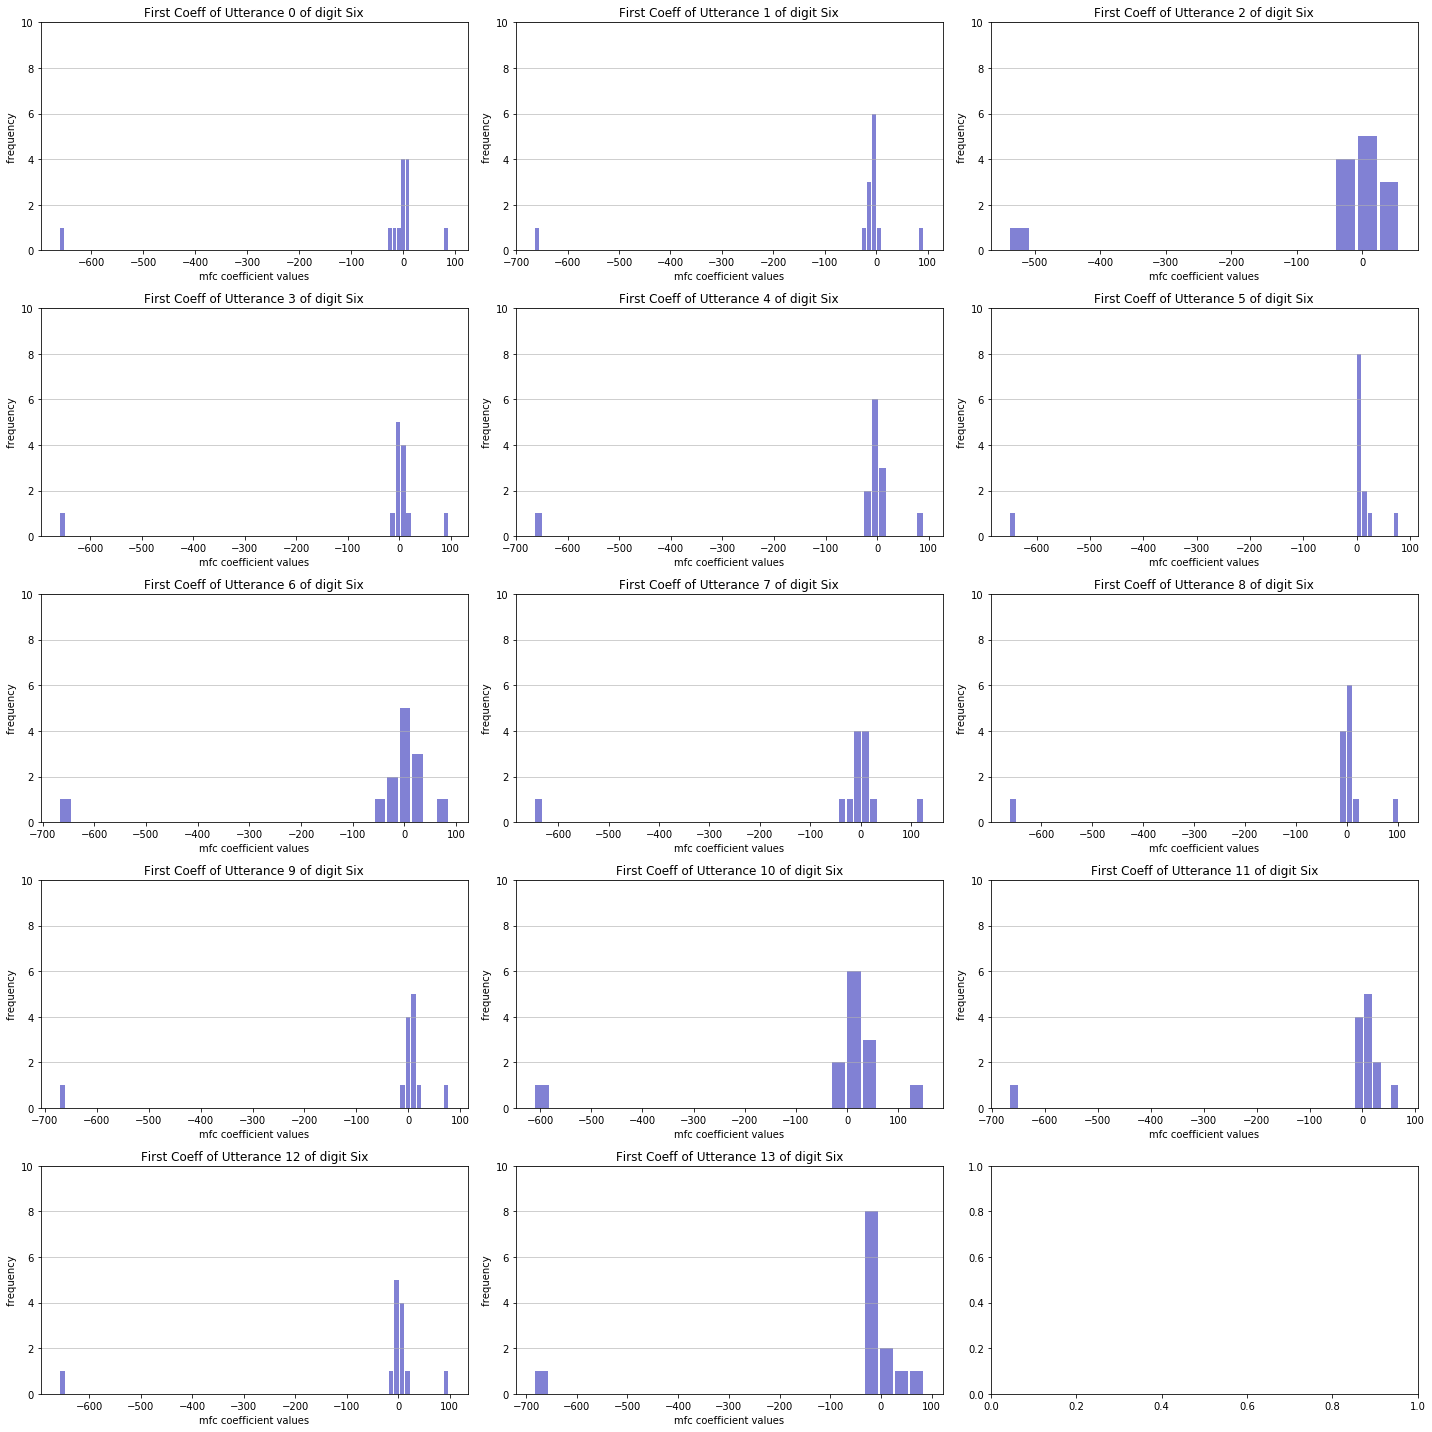

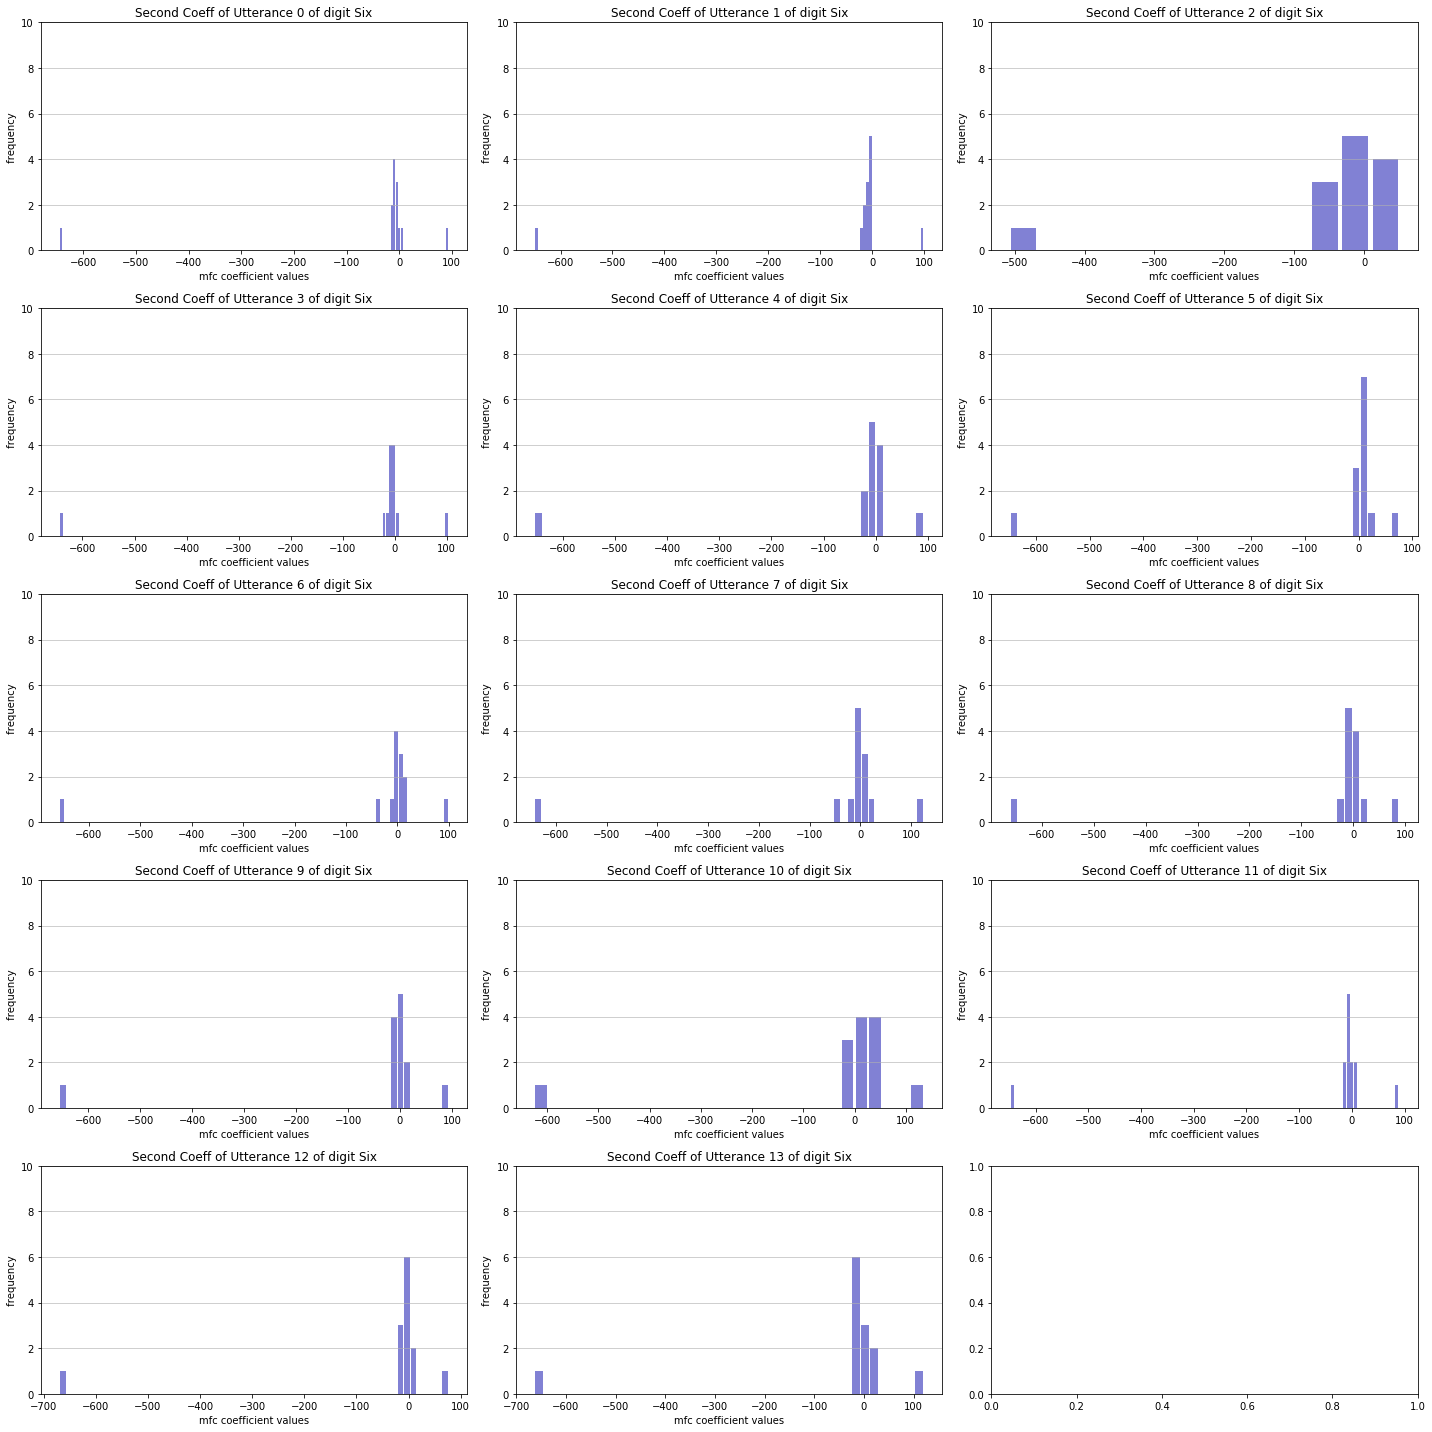

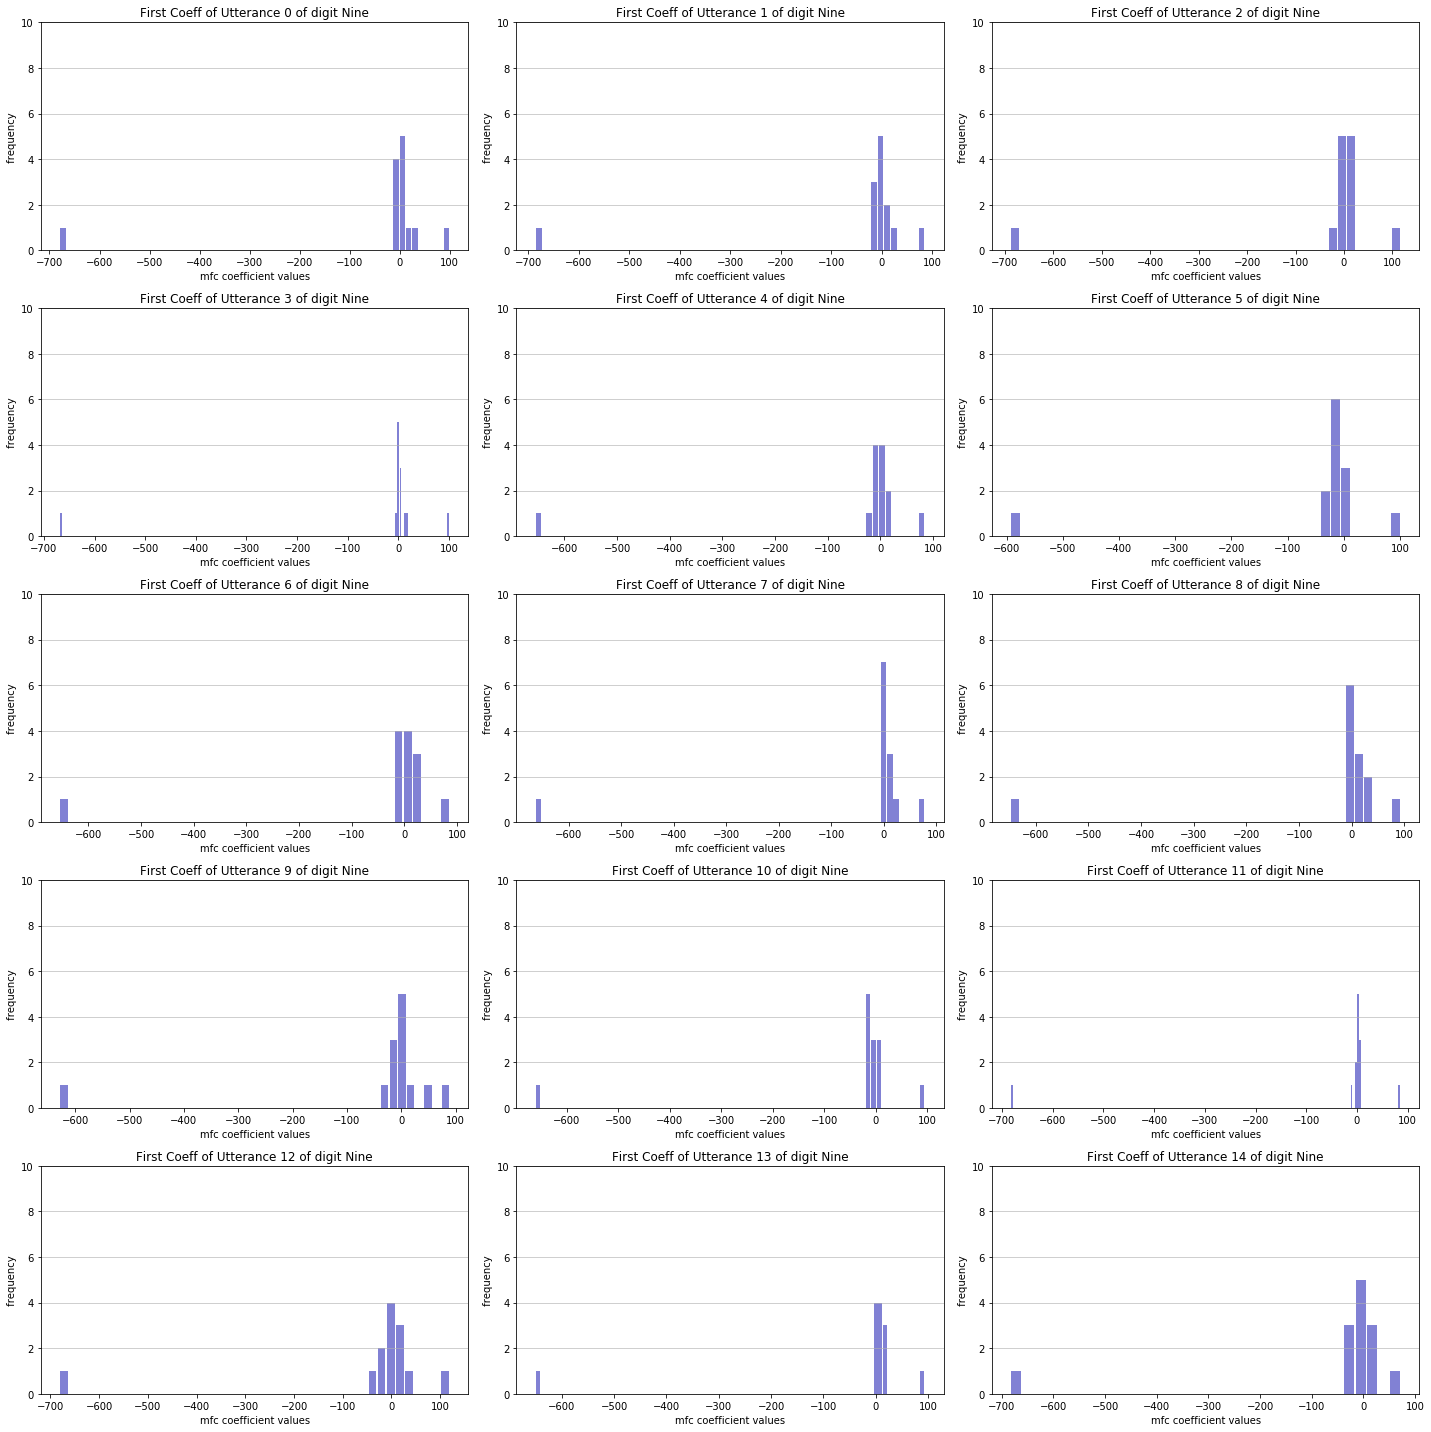

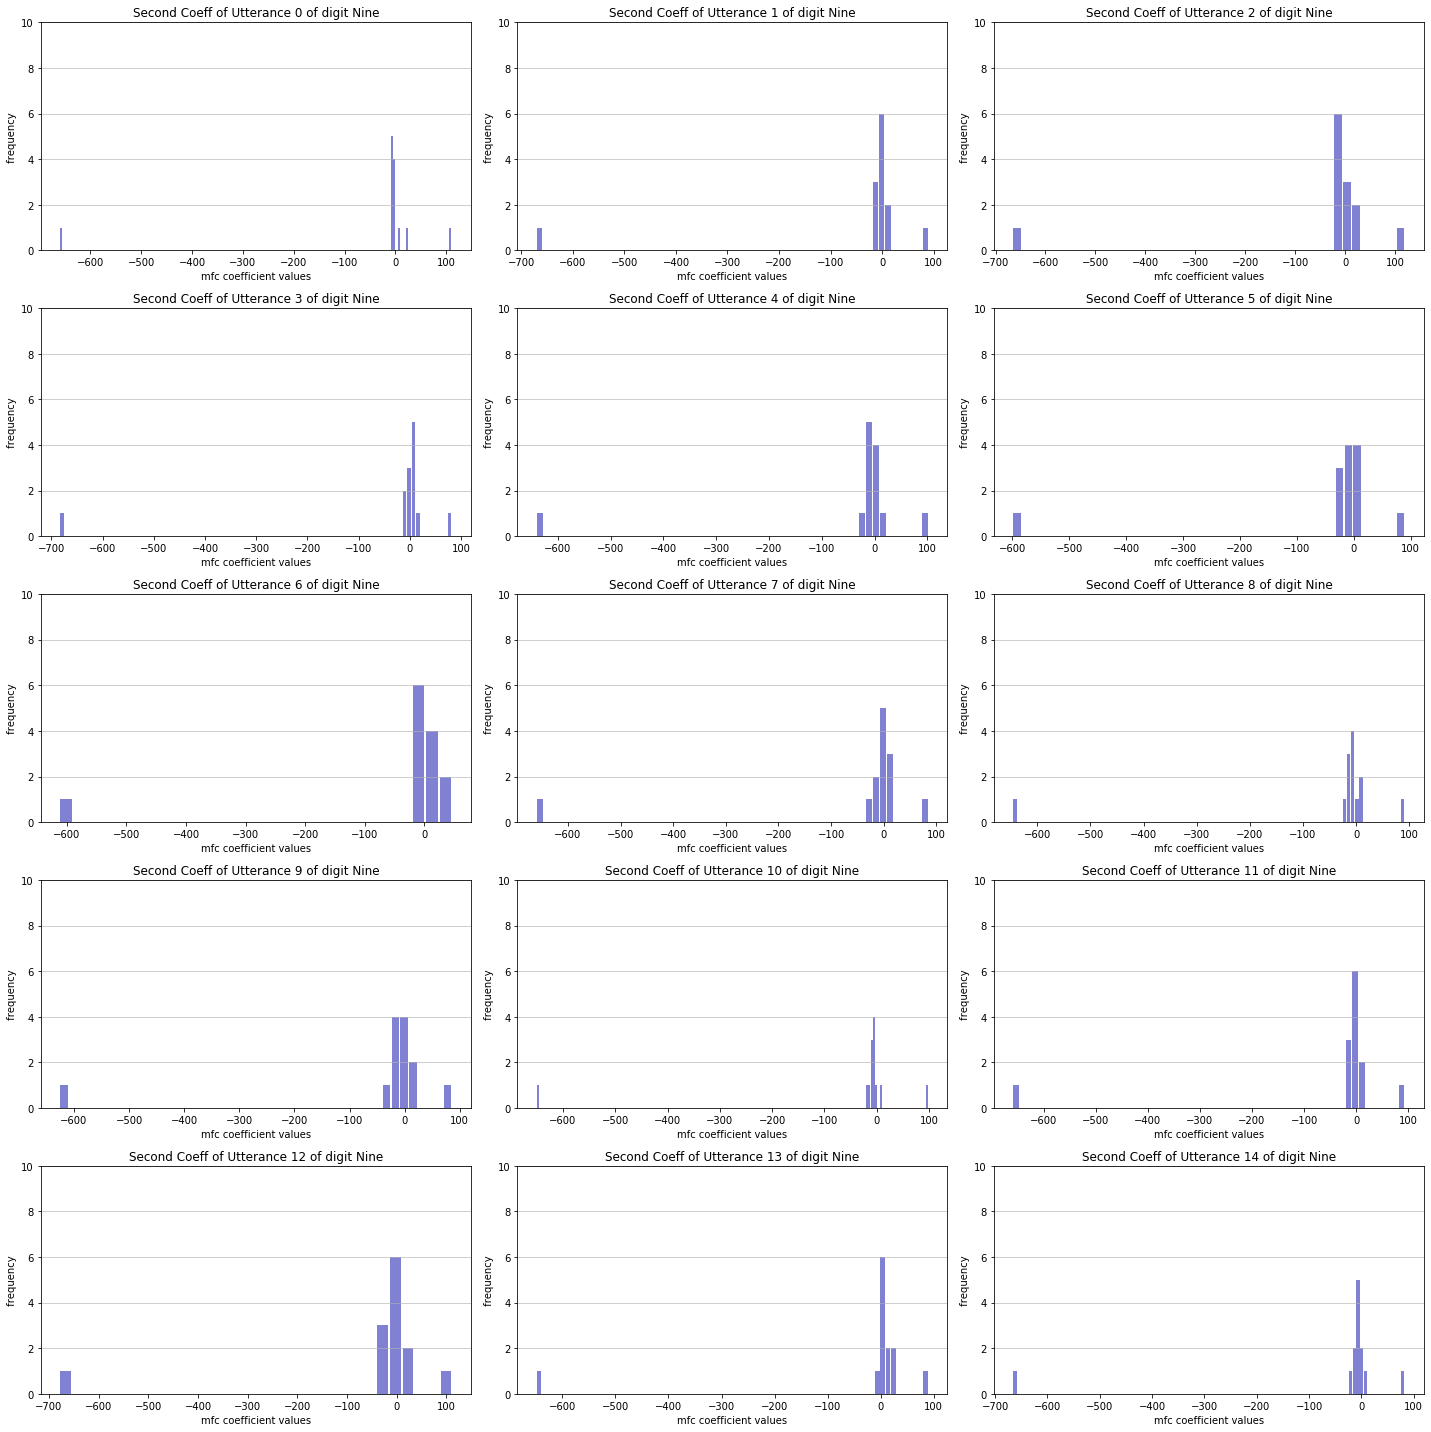

In [ ]:
hist(mfccs_n1[:,0], 'Six', 'First Coeff ')
print('\n')
hist(mfccs_n1[:,1], 'Six', 'Second Coeff ')
print('\n')
hist(mfccs_n2[:,0], 'Nine', 'First Coeff ')
print('\n')
hist(mfccs_n2[:,1], 'Nine', 'Second Coeff ')

b) MFSCs

In [ ]:
def extract_MFSCs(wavs, w_sec, s_sec, n_mels=13, Fs=16000,):
    # Extract MFCCs for all wavs
    window = int(w_sec * Fs) 
    step = int(s_sec * Fs)
    
    mfscs = [
      librosa.feature.melspectrogram(
            y=wav, sr=Fs, win_length=window, hop_length=step,
            n_mels=n_mels
        ).T #This is an array of arrays of (W X 13)
        for wav in tqdm(wavs, desc="Extracting MFSCs...")

    ]

    print("Feature extraction completed with {} mfscs per frame".format(n_mels))

    return mfscs  #This is a list, because of the difference of the signal duration(mfccs matrix is W x 13)

In [ ]:
print(indxs1)

[  0   5  13  14  25  44  55  57  58  69  76  87 118 127]


In [ ]:
n1_subwavs = list([wavs[indx] for indx in indxs1][:2])
n2_subwavs = list([wavs[indx] for indx in indxs2][:2])
n_mels = 13 #== n_mels

In [ ]:
print(len(n1_subwavs))
print(n1_subwavs[0].shape)

2
(13822,)


In [ ]:
mfscs_n1 = extract_MFSCs(n1_subwavs, w_sec, s_sec, n_mels, Fs)  #This is a list, because of the difference of the signal duration(mfccs matrix is W x 13)
mfscs_n2 = extract_MFSCs(n2_subwavs, w_sec, s_sec, n_mels, Fs)

Extracting MFSCs...: 100%|██████████| 2/2 [00:00<00:00, 73.05it/s]

Feature extraction completed with 13 mfscs per frame
Feature extraction completed with 13 mfscs per frame


In [ ]:
print(len(mfscs_n1))
print(mfscs_n1[0].shape)

2
(87, 13)


### MFCCS Correlation Matrix

For N1 = 6 

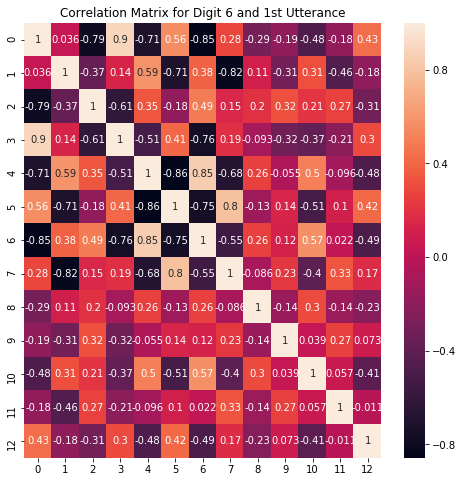

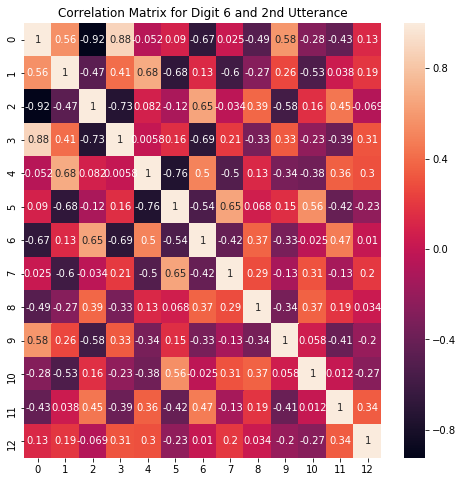

In [ ]:
# First Utterance
mfccs_n1 = [mfccs[indx] for indx in indxs1[:2]] #This is a list, because of the difference of the signal duration(mfccs matrix is W x 13)

n1_df_1 = pd.DataFrame(mfccs_n1[0])
plt.figure(figsize = (8, 8))
plt.title(f'Correlation Matrix for Digit {n1} and 1st Utterance')
sns.heatmap(n1_df_1.corr(), annot = True)
plt.show()
print('\n')

# Second Utterance
n1_df_2 = pd.DataFrame(mfccs_n1[1])
plt.figure(figsize = (8, 8))
plt.title(f'Correlation Matrix for Digit {n1} and 2nd Utterance')
ax = sns.heatmap(n1_df_2.corr(), annot = True)
plt.show()

For N2 = 9

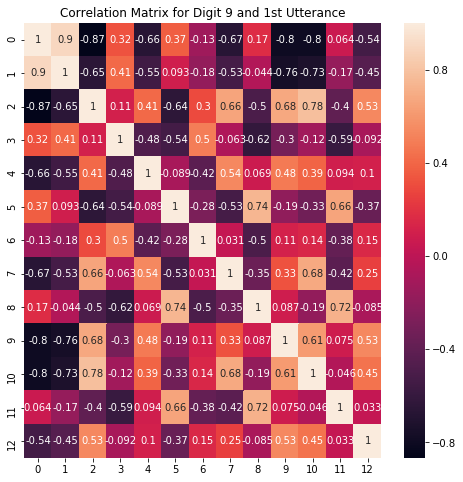

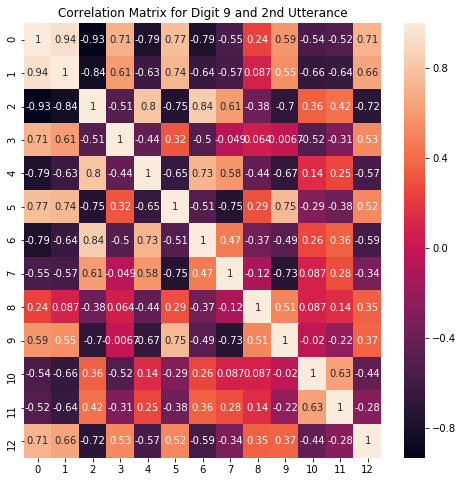

In [ ]:
# First Utterance
mfccs_n2 = [mfccs[indx] for indx in indxs2][:2] #This is a list, because of the difference of the signal duration(mfccs matrix is W x 13)

n2_df_1 = pd.DataFrame(mfccs_n2[0])
plt.figure(figsize = (8, 8))
plt.title(f'Correlation Matrix for Digit {n2} and 1st Utterance')
sns.heatmap(n2_df_1.corr(), annot = True)
plt.show()
print('\n')

# Second Utterance
n2_df_2 = pd.DataFrame(mfccs_n2[1])
plt.figure(figsize = (8, 8))
plt.title(f'Correlation Matrix for Digit {n2} and 2nd Utterance')
ax = sns.heatmap(n2_df_2.corr(), annot = True)
plt.show()


### MFSCS Correlation Matrix

For N1 = 6

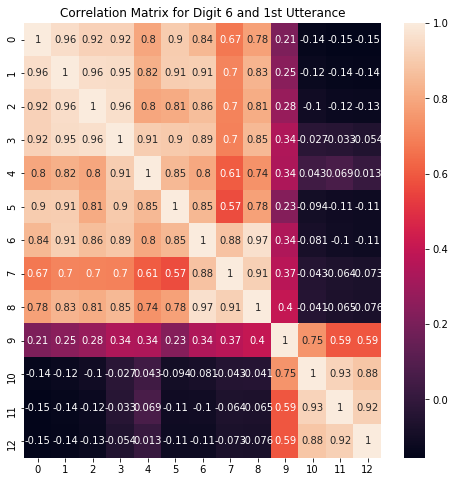

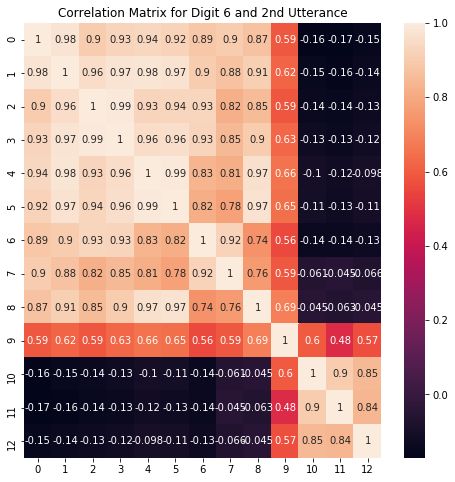

In [ ]:
# First Utterance
n1_df_1 = pd.DataFrame(mfscs_n1[0])
plt.figure(figsize = (8, 8))
plt.title(f'Correlation Matrix for Digit {n1} and 1st Utterance')
sns.heatmap(n1_df_1.corr(), annot = True)
plt.show()
print('\n')

# Second Utterance
n1_df_2 = pd.DataFrame(mfscs_n1[1])
plt.figure(figsize = (8, 8))
plt.title(f'Correlation Matrix for Digit {n1} and 2nd Utterance')
ax = sns.heatmap(n1_df_2.corr(), annot = True)
plt.show()

For N2 = 9

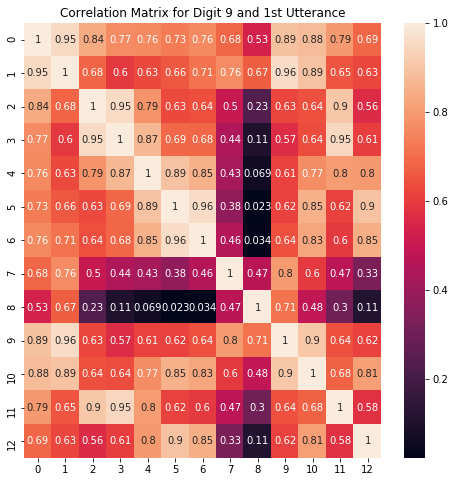

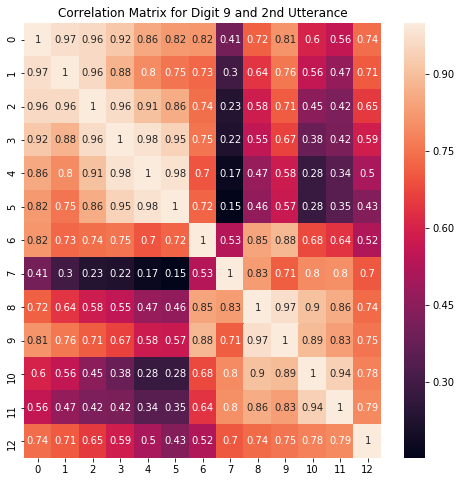

In [ ]:
# First Utterance
n2_df_1 = pd.DataFrame(mfscs_n2[0])
plt.figure(figsize = (8, 8))
plt.title(f'Correlation Matrix for Digit {n2} and 1st Utterance')
sns.heatmap(n2_df_1.corr(), annot = True)
plt.show()
print('\n')

# Second Utterance
n2_df_2 = pd.DataFrame(mfscs_n2[1])
plt.figure(figsize = (8, 8))
plt.title(f'Correlation Matrix for Digit {n2} and 2nd Utterance')
ax = sns.heatmap(n2_df_2.corr(), annot = True)
plt.show()


## Task 5 - Unique Data Representation / Scatter Plot

In [ ]:
means = np.zeros((133, 39))
stds = np.zeros((133, 39))
for i in range (len(mfccs)):
  sample = np.concatenate((mfccs[i],mfcc_deltas[i],mfcc_delta2s[i]),axis=1) # (X,39), where X:unkonw
  mean = np.mean(sample,axis=0)
  std = np.std(sample,axis=0)
  means[i] = mean
  stds[i] = std


print(means.shape)#(133,39)
print(stds.shape) #(133,39)

(133, 39)
(133, 39)


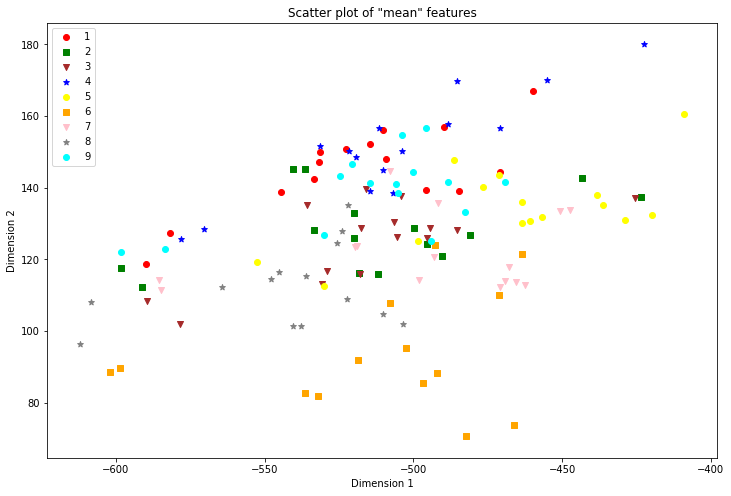

In [ ]:
markers = ['o', 's', 'v', '*', 'o', 's', 'v', '*','o']
# colors = cm.rainbow(np.linspace(0, 1, len(markers)))
colors = ['red', 'green', 'brown', 'blue', 'yellow', 'orange', 'pink','gray', 'cyan']

plt.figure(figsize=(12,8))

for digit, marker, color in zip(set(digits), markers, colors):

  indxs = np.where(digits==digit)[0]
  mean = np.array([means[indx] for indx in indxs])  

  plt.scatter(mean[:, 0], mean[:, 1], c=color, marker=marker, label=digit)

plt.legend()
plt.title('Scatter plot of "mean" features')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

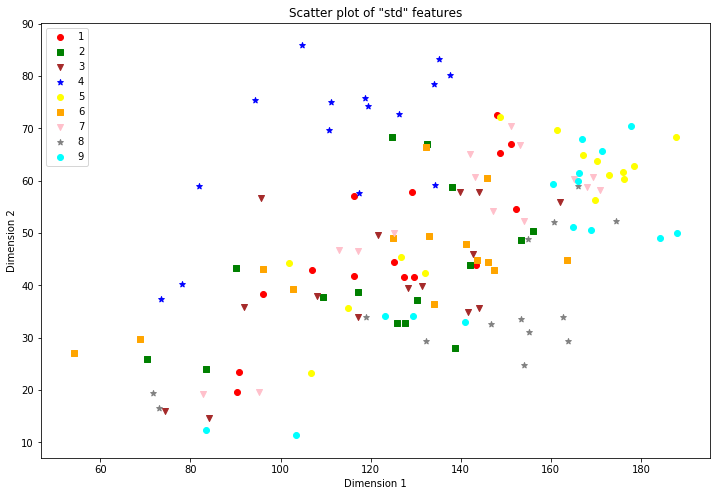

In [ ]:
markers = ['o', 's', 'v', '*', 'o', 's', 'v', '*','o']
# colors = cm.rainbow(np.linspace(0, 1, len(markers)))
colors = ['red', 'green', 'brown', 'blue', 'yellow', 'orange', 'pink','gray', 'cyan']

plt.figure(figsize=(12,8))

for digit, marker, color in zip(set(digits), markers, colors):

  indxs = np.where(digits==digit)[0]
  std = np.array([stds[indx] for indx in indxs])  

  plt.scatter(std[:, 0], std[:, 1], c=color, marker=marker, label=digit)

plt.legend()
plt.title('Scatter plot of "std" features')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

## Task 6 - PCA Method

### 2D

In [ ]:
pca_mean = PCA(n_components=2)
pca_std = PCA(n_components=2)

_means = pca_mean.fit_transform(means)
_stds = pca_std.fit_transform(stds)

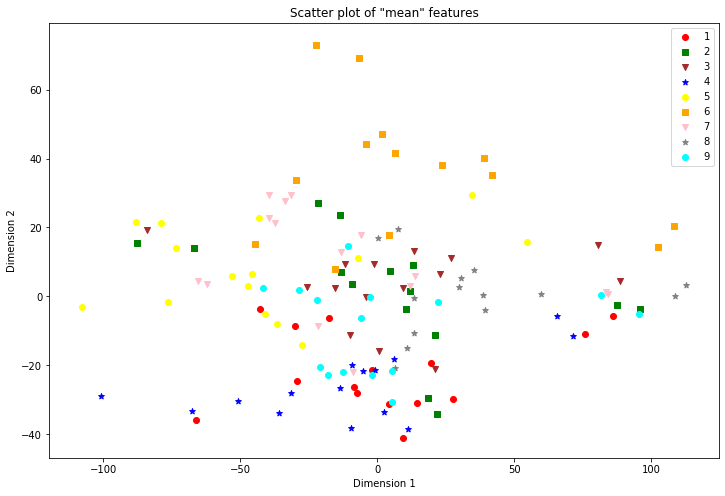

In [ ]:
markers = ['o', 's', 'v', '*', 'o', 's', 'v', '*','o']
# colors = cm.rainbow(np.linspace(0, 1, len(markers)))
colors = ['red', 'green', 'brown', 'blue', 'yellow', 'orange', 'pink','gray', 'cyan']

plt.figure(figsize=(12,8))

for digit, marker, color in zip(set(digits), markers, colors):

  indxs = np.where(digits==digit)[0]
  _mean = np.array([_means[indx] for indx in indxs])  

  plt.scatter(_mean[:, 0], _mean[:, 1], c=color, marker=marker, label=digit)

plt.legend()
plt.title('Scatter plot of "mean" features')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

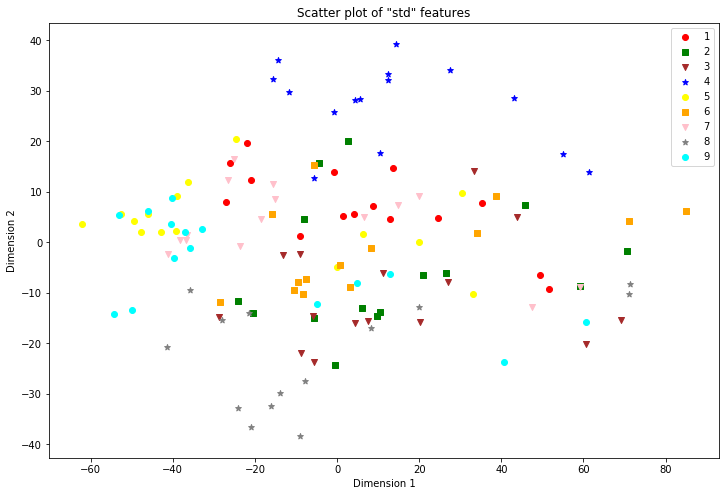

In [ ]:
markers = ['o', 's', 'v', '*', 'o', 's', 'v', '*','o']
# colors = cm.rainbow(np.linspace(0, 1, len(markers)))
colors = ['red', 'green', 'brown', 'blue', 'yellow', 'orange', 'pink','gray', 'cyan']

plt.figure(figsize=(12,8))

for digit, marker, color in zip(set(digits), markers, colors):

  indxs = np.where(digits==digit)[0]
  _std = np.array([_stds[indx] for indx in indxs])  

  plt.scatter(_std[:, 0], _std[:, 1], c=color, marker=marker, label=digit)

plt.legend()
plt.title('Scatter plot of "std" features')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [ ]:
print(pca_mean.explained_variance_ratio_)
print(pca_std.explained_variance_ratio_)

[0.66979977 0.14992746]
[0.69178909 0.15685564]


### 3D

In [ ]:
pca_mean = PCA(n_components=3)
pca_std = PCA(n_components=3)

_means3 = pca_mean.fit_transform(means)
_stds3 = pca_std.fit_transform(stds)

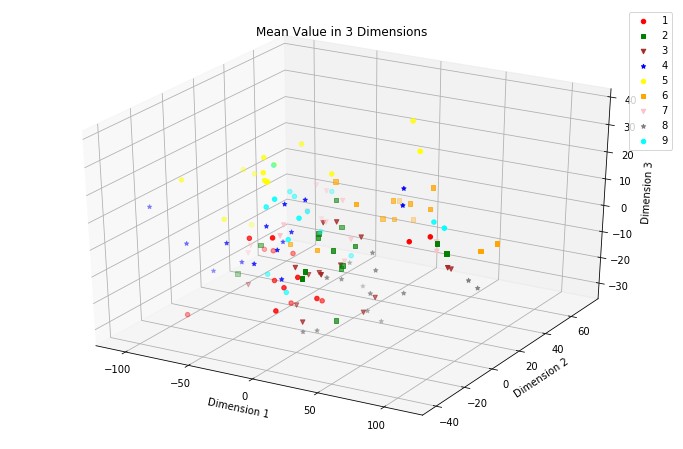

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')

markers = ['o', 's', 'v', '*', 'o', 's', 'v', '*','o']
# colors = cm.rainbow(np.linspace(0, 1, len(markers)))
colors = ['red', 'green', 'brown', 'blue', 'yellow', 'orange', 'pink','gray', 'cyan']


for digit, marker, color in zip(set(digits), markers, colors):

  indxs = np.where(digits==digit)[0]
  _mean3 = np.array([_means3[indx] for indx in indxs])  

  ax.scatter(_mean3[:, 0], _mean3[:, 1], _mean3[:, 2], c=color, marker=marker, label=digit)

plt.legend(loc='best')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.set_title('Mean Value in 3 Dimensions')
plt.show()

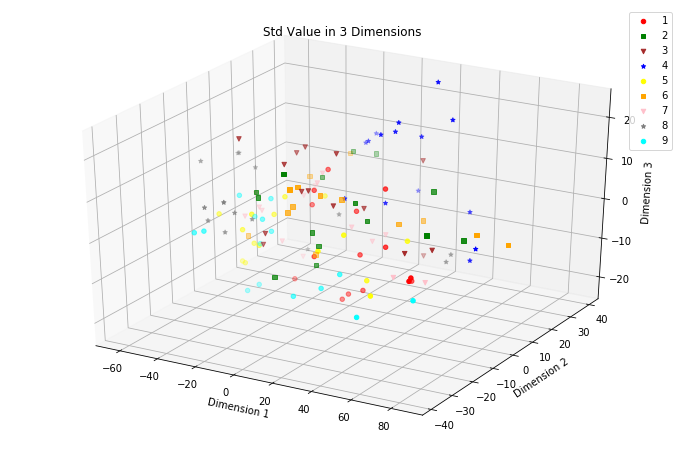

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')

markers = ['o', 's', 'v', '*', 'o', 's', 'v', '*','o']
# colors = cm.rainbow(np.linspace(0, 1, len(markers)))
colors = ['red', 'green', 'brown', 'blue', 'yellow', 'orange', 'pink','gray', 'cyan']


for digit, marker, color in zip(set(digits), markers, colors):

  indxs = np.where(digits==digit)[0]
  _std3 = np.array([_stds3[indx] for indx in indxs])  

  ax.scatter(_std3[:, 0], _std3[:, 1], _std3[:, 2], c=color, marker=marker, label=digit)

plt.legend(loc='best')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.set_title('Std Value in 3 Dimensions')
plt.show()

In [ ]:
print(pca_mean.explained_variance_ratio_)
print(pca_std.explained_variance_ratio_)

[0.66979977 0.14992746 0.06334463]
[0.69178909 0.15685564 0.06599284]


## Task 7 - Estimators Comparison for Digit Classification

In [ ]:
def evaluate_clasifier(clf, X_train, y_train, X_test, y_test, folds=10):
    clf_clone = sklearn.base.clone(clf)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)  # calculate accuracy
    f1 = f1_score(y_test, y_pred, average='macro')  # calculate f1-score
    cross_val_acc = cross_val_score(clf_clone, X_train, y_train, cv=KFold(n_splits=folds), scoring="accuracy")  # calculate k-fold-cross-validation accuracy score
    cross_val_f1 = cross_val_score(clf_clone, X_train, y_train, cv=KFold(n_splits=folds), scoring="f1_macro")  # calculate k-fold-cross-validation f1 score
    return acc, f1, cross_val_acc, cross_val_f1


def Classifiers_evaluation(X_train, y_train, X_test, y_test, clfs=[CustomNBClassifier(), GaussianNB(), DummyClassifier(), KNeighborsClassifier(n_neighbors=5), LogisticRegression()]):
  warnings.filterwarnings('ignore') # ignore warning messages
  scores_default = {}
  for clf in clfs:
      s1, s2, s3, s4 = evaluate_clasifier(clf, X_train, y_train, X_test, y_test, folds=10)
      scores_default[str(clf).split('(')[0]] = [s1, s2, np.mean(s3), np.std(s3), np.mean(s4), np.std(s4)]
  return scores_default


def display_results(X_train, y_train, X_test, y_test, clfs=[CustomNBClassifier(), GaussianNB(), DummyClassifier(), KNeighborsClassifier(n_neighbors=5), LogisticRegression()]):
  scores_default = Classifiers_evaluation(X_train, y_train, X_test, y_test, clfs)
  
  columns_labels = ['Classifier', 'Accuracy', 'F1-Score', '10-Fold Cross-Validation-Accuracy-Score', '10-Fold Cross-Validation-F1-Score']

  clfs_names = [str(clfs[0]).split('(')[0], str(clfs[1]).split('(')[0], str(clfs[2]).split('(')[0], str(clfs[3]).split('(')[0], str(clfs[4]).split('(')[0]]

  acc = [scores_default[clfs_names[0]][0], scores_default[clfs_names[1]][0], scores_default[clfs_names[2]][0], scores_default[clfs_names[3]][0], scores_default[clfs_names[4]][0]]

  f1 = [scores_default[clfs_names[0]][1], scores_default[clfs_names[1]][1], scores_default[clfs_names[2]][1], scores_default[clfs_names[3]][1], scores_default[clfs_names[4]][1]]

  cross_val_acc_means = [scores_default[clfs_names[0]][2], scores_default[clfs_names[1]][2], scores_default[clfs_names[2]][2], scores_default[clfs_names[3]][2], scores_default[clfs_names[4]][2]]
  cross_val_acc_stds = [scores_default[clfs_names[0]][3], scores_default[clfs_names[1]][3], scores_default[clfs_names[2]][3], scores_default[clfs_names[3]][3], scores_default[clfs_names[4]][3]]

  cross_val_f1_means = [scores_default[clfs_names[0]][4], scores_default[clfs_names[1]][4], scores_default[clfs_names[2]][4], scores_default[clfs_names[3]][4], scores_default[clfs_names[4]][4]]
  cross_val_f1_stds = [scores_default[clfs_names[0]][5], scores_default[clfs_names[1]][5], scores_default[clfs_names[2]][5], scores_default[clfs_names[3]][5], scores_default[clfs_names[4]][5]]
  cross_val_acc = []
  cross_val_f1 = []
  for i in range(5):
      cross_val_acc.append(str(str(cross_val_acc_means[i]) + ' +- ' + str(cross_val_acc_stds[i])))
      cross_val_f1.append(str(str(cross_val_f1_means[i]) + ' +- ' + str(cross_val_f1_stds[i])))

  values = zip(clfs_names, acc, f1, cross_val_acc, cross_val_f1)

  cm = sns.light_palette("pink", as_cmap=True)

  df1 = pd.DataFrame(values, columns=columns_labels)
  pd.options.display.float_format = "{:.3f}".format

  df1.style.set_caption("Scores of Classifiers")\
      .background_gradient(cmap=cm)

  display(df1)

*   1st Implementation [Vertical Stacking] -- X_data : (266x39)

In [ ]:
# create dataset
X_data = StandardScaler().fit_transform(np.concatenate((means,stds)))
y_data = np.concatenate((digits,digits))
print('Initial-dataset shape: {}'.format(X_data.shape))

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.3) # slice dataset using function from scikit-learn
print('Train-set shape: {}, {}'.format(X_train.shape, y_train.shape)) # print the shapes for testing
print('Test-set shapes: {}, {}'.format(X_test.shape, y_test.shape)) # print the shapes for testing

Initial-dataset shape: (266, 39)
Train-set shape: (186, 39), (186,)
Test-set shapes: (80, 39), (80,)


In [ ]:
display_results(X_train, y_train, X_test, y_test, clfs=[CustomNBClassifier(), GaussianNB(), DummyClassifier(), KNeighborsClassifier(n_neighbors=5), LogisticRegression()])

,Classifier,Accuracy,F1-Score,10-Fold Cross-Validation-Accuracy-Score,10-Fold Cross-Validation-F1-Score
0,CustomNBClassifier,0.113,0.022,0.11286549707602338 +- 0.07721955948652193,0.023370626692995115 +- 0.015181728193252898
1,GaussianNB,0.263,0.269,0.26315789473684215 +- 0.1214841026474671,0.22150412858746193 +- 0.14249868433095167
2,DummyClassifier,0.100,0.091,0.09707602339181286 +- 0.0633606233019034,0.10763668430335098 +- 0.06353584861017249
3,KNeighborsClassifier,0.525,0.532,0.4681286549707602 +- 0.12317856632191217,0.42830236892736895 +- 0.13595243038418497
4,LogisticRegression,0.537,0.510,0.5695906432748539 +- 0.1288130342160044,0.5084766313932981 +- 0.12943525879601242


*   2nd Implementation [Vertical Stacking with PCA] -- X_data : (266x5)

In [ ]:
X_data = PCA(n_components=5).fit_transform(X_data)
print('Initial-dataset shape: {}'.format(X_data.shape))

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.3) # slice dataset using function from scikit-learn
print('Train-set shape: {}, {}'.format(X_train.shape, y_train.shape)) # print the shapes for testing
print('Test-set shapes: {}, {}'.format(X_test.shape, y_test.shape)) # print the shapes for testing

Initial-dataset shape: (266, 5)
Train-set shape: (186, 5), (186,)
Test-set shapes: (80, 5), (80,)


In [ ]:
display_results(X_train, y_train, X_test, y_test, clfs=[CustomNBClassifier(), GaussianNB(), DummyClassifier(), KNeighborsClassifier(n_neighbors=5), LogisticRegression()])

,Classifier,Accuracy,F1-Score,10-Fold Cross-Validation-Accuracy-Score,10-Fold Cross-Validation-F1-Score
0,CustomNBClassifier,0.125,0.025,0.1067251461988304 +- 0.06207169167853321,0.024041070152953124 +- 0.01256968201675425
1,GaussianNB,0.400,0.343,0.3669590643274853 +- 0.1433121445682572,0.3193455387205387 +- 0.13716478215123962
2,DummyClassifier,0.100,0.086,0.14619883040935672 +- 0.08154697648487295,0.07813161375661377 +- 0.05597987298266959
3,KNeighborsClassifier,0.562,0.535,0.35058479532163744 +- 0.08536259132794455,0.3007440476190476 +- 0.06094083314437344
4,LogisticRegression,0.438,0.374,0.2903508771929824 +- 0.10427615565218107,0.24728678508440413 +- 0.09763618191056377


*   3rd Implementation [Horizontal Stacking] -- X_data : (133x78)

In [ ]:
# create dataset
X_data = StandardScaler().fit_transform(np.concatenate((means,stds),axis=-1))
y_data = digits
print('Initial-dataset shape: {}'.format(X_data.shape))

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.3) # slice dataset using function from scikit-learn
print('Train-set shape: {}, {}'.format(X_train.shape, y_train.shape)) # print the shapes for testing
print('Test-set shapes: {}, {}'.format(X_test.shape, y_test.shape)) # print the shapes for testing

Initial-dataset shape: (133, 78)
Train-set shape: (93, 78), (93,)
Test-set shapes: (40, 78), (40,)


In [ ]:
display_results(X_train, y_train, X_test, y_test, clfs=[CustomNBClassifier(), GaussianNB(), DummyClassifier(), KNeighborsClassifier(n_neighbors=5), LogisticRegression()])

,Classifier,Accuracy,F1-Score,10-Fold Cross-Validation-Accuracy-Score,10-Fold Cross-Validation-F1-Score
0,CustomNBClassifier,0.100,0.020,0.12 +- 0.10515127257174203,0.03179220779220779 +- 0.026666429132579005
1,GaussianNB,0.675,0.714,0.6366666666666666 +- 0.17199267856941317,0.5495767195767195 +- 0.18439275655656848
2,DummyClassifier,0.125,0.121,0.07555555555555556 +- 0.08603760303380417,0.08176587301587303 +- 0.06902198313094747
3,KNeighborsClassifier,0.450,0.501,0.5411111111111111 +- 0.22487582307235504,0.47863888888888895 +- 0.23728927746513198
4,LogisticRegression,0.750,0.742,0.8066666666666669 +- 0.10578337987032806,0.7292526455026456 +- 0.1571155258385358


*   4th Implementation [Horizontal Stacking with PCA] -- X_data : (133x5)

In [ ]:
X_data = PCA(n_components=5).fit_transform(X_data)
print('Initial-dataset shape: {}'.format(X_data.shape))

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.3) # slice dataset using function from scikit-learn
print('Train-set shape: {}, {}'.format(X_train.shape, y_train.shape)) # print the shapes for testing
print('Test-set shapes: {}, {}'.format(X_test.shape, y_test.shape)) # print the shapes for testing

Initial-dataset shape: (133, 5)
Train-set shape: (93, 5), (93,)
Test-set shapes: (40, 5), (40,)


In [ ]:
display_results(X_train, y_train, X_test, y_test, clfs=[CustomNBClassifier(), GaussianNB(), DummyClassifier(), KNeighborsClassifier(n_neighbors=5), LogisticRegression()])

,Classifier,Accuracy,F1-Score,10-Fold Cross-Validation-Accuracy-Score,10-Fold Cross-Validation-F1-Score
0,CustomNBClassifier,0.175,0.037,0.08666666666666667 +- 0.06607141665474892,0.024448051948051948 +- 0.020673344192418387
1,GaussianNB,0.500,0.457,0.43888888888888883 +- 0.1195929309608326,0.3268915343915344 +- 0.10056975037931645
2,DummyClassifier,0.075,0.086,0.09777777777777777 +- 0.09213516640723501,0.11488756613756612 +- 0.0641519149030727
3,KNeighborsClassifier,0.475,0.458,0.48 +- 0.1468853588414288,0.3449404761904762 +- 0.1192739663685583
4,LogisticRegression,0.375,0.345,0.5133333333333334 +- 0.11995884067791802,0.3807883597883598 +- 0.10382999834494563


*   5th Implementation [Extra Feautures / Zero Crossing Rate] -- X_data : (266x40)

In [ ]:
# Add a new feature to data

means_new = np.zeros((133, 40))
stds_new = np.zeros((133, 40))

for i in range (len(mfccs)):
  zcrs = librosa.feature.zero_crossing_rate(wavs[i],frame_length=400, hop_length=160)
  sample = np.concatenate((mfccs[i],mfcc_deltas[i],mfcc_delta2s[i],zcrs.T),axis=1) # (X,40), where X:unkonw
  mean = np.mean(sample,axis=0)
  std = np.std(sample,axis=0)
  means_new[i] = mean
  stds_new[i] = std

print(means_new.shape) #(133,40)
print(stds_new.shape) #(133,40)

(133, 40)
(133, 40)


In [ ]:
# create dataset
X_data = StandardScaler().fit_transform(np.concatenate((means_new,stds_new)))
y_data = np.concatenate((digits,digits))
print('Initial-dataset shape: {}'.format(X_data.shape))

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.3) # slice dataset using function from scikit-learn
print('Train-set shape: {}, {}'.format(X_train.shape, y_train.shape)) # print the shapes for testing
print('Test-set shapes: {}, {}'.format(X_test.shape, y_test.shape)) # print the shapes for testing

Initial-dataset shape: (266, 40)
Train-set shape: (186, 40), (186,)
Test-set shapes: (80, 40), (80,)


In [ ]:
display_results(X_train, y_train, X_test, y_test, clfs=[CustomNBClassifier(), GaussianNB(), DummyClassifier(), KNeighborsClassifier(n_neighbors=5), LogisticRegression()])

,Classifier,Accuracy,F1-Score,10-Fold Cross-Validation-Accuracy-Score,10-Fold Cross-Validation-F1-Score
0,CustomNBClassifier,0.087,0.018,0.12339181286549708 +- 0.05895711420411021,0.02578787729408847 +- 0.01223728146872295
1,GaussianNB,0.350,0.341,0.31695906432748533 +- 0.08168525216540756,0.2781740944240944 +- 0.09894478135645647
2,DummyClassifier,0.113,0.108,0.12280701754385966 +- 0.05692374951442042,0.09396825396825395 +- 0.05162592503390623
3,KNeighborsClassifier,0.562,0.567,0.4619883040935672 +- 0.09063384218039473,0.3763403880070547 +- 0.06920621268371564
4,LogisticRegression,0.600,0.580,0.547953216374269 +- 0.09817945419251159,0.48731470579684866 +- 0.11413070805960311


## Task 8 - RNN Regression

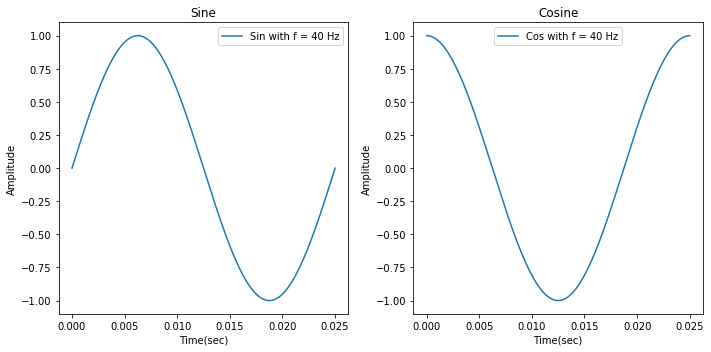

In [4]:
# Make an instance of the sin with f = 40Hz
f = 40
w = 2*np.pi*f
T = 1/f
samples = 1000

t = np.linspace(0, T, samples)

# Input Data prototype
s = np.sin(w*t)

# Output Data prototype
c = np.cos(w*t)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(t, s, label='Sin with f = 40 Hz')
plt.title("Sine")
plt.xlabel('Time(sec)')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(1,2,2)
plt.plot(t, c, label='Cos with f = 40 Hz')
plt.title("Cosine")
plt.xlabel('Time(sec)')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
data_size = 10

s_data = []
c_data = []

for i in range (0,len(s),10):
  s_data.append(s[i:i+10])
  c_data.append(c[i:i+10])

s_data = np.array(s_data)
c_data = np.array(c_data)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(s_data, c_data, test_size = 0.3) # slice dataset using function from scikit-learn
print('Train-set shape: {}, {}'.format(X_train.shape, y_train.shape)) # print the shapes for testing
print('Test-set shape: {}, {}'.format(X_test.shape, y_test.shape)) # print the shapes for testing

Train-set shape: (70, 10), (70, 10)
Test-set shape: (30, 10), (30, 10)


In [7]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

#reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Train-set shape: ", X_train_tensors_final.shape, y_train_tensors.shape)
print("Test-set shape: ", X_test_tensors_final.shape, y_test_tensors.shape) 

Train-set shape:  torch.Size([70, 1, 10]) torch.Size([70, 10])
Test-set shape:  torch.Size([30, 1, 10]) torch.Size([30, 10])


In [8]:
# define class for modeling our task
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, batch_first=True):
        super(LSTM, self).__init__()      
        self.hidden_layer = hidden_size #hidden state
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=batch_first) #define the lstm
        self.hiddenlayer = nn.Linear(hidden_size, hidden_size//2) #define the hidden linear layer
        self.outlayer = nn.Linear(hidden_size//2, output_size) #define the final linear layer which maps
        self.relu = nn.ReLU() #define activation function


    def forward(self, X):
        # propagate input through LSTM
        output, (hn,cn) = self.lstm(X)
        hn = hn.view(-1, self.hidden_layer) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.hiddenlayer(out) #first Dense
        out = self.relu(out) #relu
        out = self.outlayer(out) #Final Output
        return out

In [9]:
num_epochs = 2000 #2000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 10 #number of features
hidden_size = 5 #number of features in hidden state
output_size = 10 #number of output classes 

In [10]:
lstm = LSTM(input_size, hidden_size, output_size) #our lstm class 

In [11]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate) 

In [12]:
for epoch in range(num_epochs):
  outputs = lstm.forward(X_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
 
  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.78133
Epoch: 100, loss: 0.64547
Epoch: 200, loss: 0.58080
Epoch: 300, loss: 0.54154
Epoch: 400, loss: 0.50953
Epoch: 500, loss: 0.46745
Epoch: 600, loss: 0.39628
Epoch: 700, loss: 0.27716
Epoch: 800, loss: 0.14702
Epoch: 900, loss: 0.08819
Epoch: 1000, loss: 0.06151
Epoch: 1100, loss: 0.04646
Epoch: 1200, loss: 0.03618
Epoch: 1300, loss: 0.02860
Epoch: 1400, loss: 0.02285
Epoch: 1500, loss: 0.01834
Epoch: 1600, loss: 0.01477
Epoch: 1700, loss: 0.01192
Epoch: 1800, loss: 0.00962
Epoch: 1900, loss: 0.00777


In [13]:
df_X = Variable(torch.Tensor(s_data)) #converting to Tensors
df_y = Variable(torch.Tensor(c_data))
#reshaping the dataset
df_X = torch.reshape(df_X, (df_X.shape[0], 1, df_X.shape[1]))

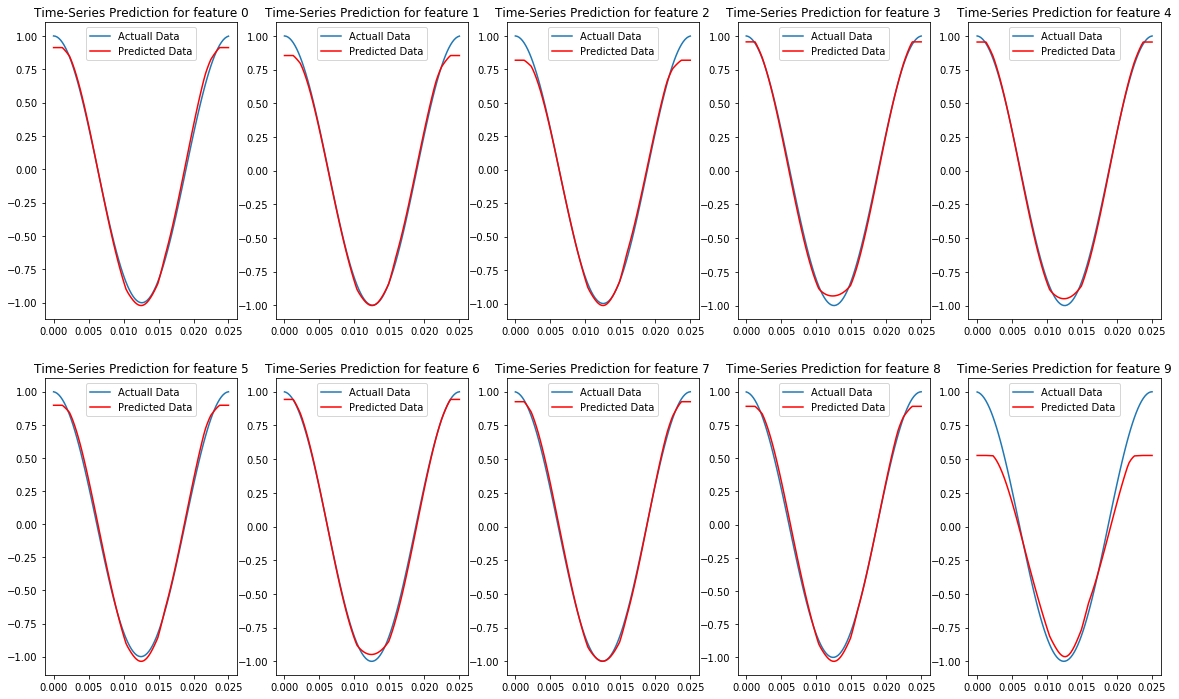

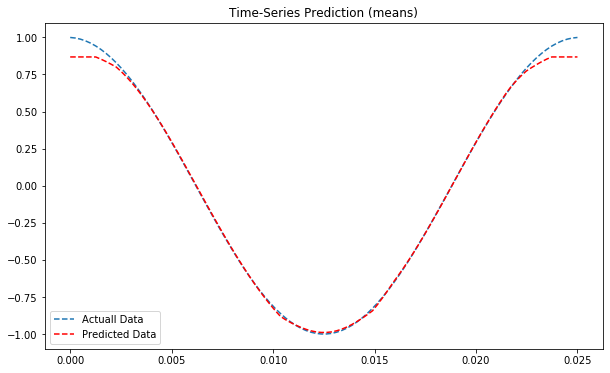

In [14]:
train_predict = lstm(df_X)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y.data.numpy()

#plt.figure(figsize=(10,6)) #plotting
#plt.axvline(x=200, c='r', linestyle='--') #size of the training set

tt = np.linspace(0, T, len(dataY_plot))

plt.figure(figsize=(20,12))
for i in range (0,10,1):
  plt.subplot(2, 5, i+1)
  plt.plot(tt, dataY_plot[:,i], label='Actuall Data') #actual plot 
  plt.plot(tt, data_predict[:,i], label='Predicted Data',color='red') #predicted plot
  plt.title('Time-Series Prediction for feature {}'.format(i))
  plt.legend()
plt.show() 

print('\n')

plt.figure(figsize=(10,6)) #plotting
plt.plot(tt, np.mean(dataY_plot,axis=-1), label='Actuall Data', linestyle='--') #actual plot 
plt.plot(tt, np.mean(data_predict,axis=-1), label='Predicted Data',color='red', linestyle='--') #predicted plot
plt.title('Time-Series Prediction (means)')
plt.legend()
plt.show() 

## Task 9 - Stratified Split



In [2]:
#!pip freeze | grep joblib

joblib==0.17.0


In [3]:
#!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git

Cloning into 'free-spoken-digit-dataset'...
remote: Enumerating objects: 4234, done.
remote: Counting objects: 100% (562/562), done.
remote: Compressing objects: 100% (550/550), done.
remote: Total 4234 (delta 31), reused 524 (delta 12), pack-reused 3672
Receiving objects: 100% (4234/4234), 30.45 MiB | 18.08 MiB/s, done.
Resolving deltas: 100% (108/108), done.


In [4]:
X_train, X_test, y_train, y_test, spk_train, spk_test = parser('./free-spoken-digit-dataset/recordings/')


Extracting mfcc features...:   0%|          | 14/3000 [00:00<00:21, 138.95it/s]

Total wavs: 3000. Fs = 8000 Hz


Extracting mfcc features...: 100%|██████████| 3000/3000 [00:25<00:00, 119.40it/s]



Feature extraction completed with 13 mfccs per frame!
Splitting in train test split using the default dataset split


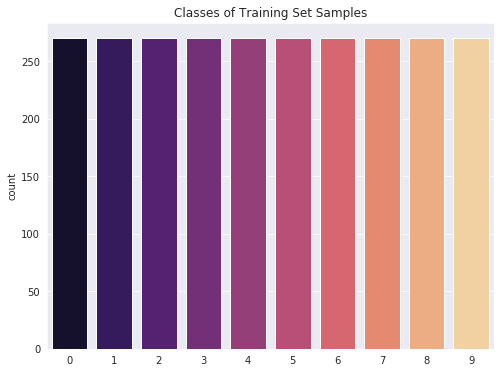

In [5]:
sns.set_style('darkgrid')
plt.figure(figsize = (8, 6))
#fig, axes = plt.subplots(1, 2)
sns.countplot(x=y_train, palette = 'magma')#, ax=axes[0])
#sns.countplot(y_train, palette = 'magma', ax= axes[1])
plt.title("Classes of Training Set Samples")
plt.show()

We can observe, the balance of the dataset between the classes. In case that, it were not balanced, we might use RandomOverSampler to make the proportions equal.

In [6]:
print(X_train[1].shape)

(50, 13)


In [7]:
sss = StratifiedShuffleSplit(n_splits=1, test_size = 0.2, random_state=0)

# Convert type
X_test = [x_test.astype('float64') for x_test in X_test]
for train_index, dev_index in sss.split(X_train, y_train):
    X_dev = [X_train[indx].astype('float64') for indx in dev_index]
    X_train = [X_train[indx].astype('float64') for indx in train_index]
    y_dev = [y_train[indx] for indx in dev_index]
    y_train = [y_train[indx] for indx in train_index]
    

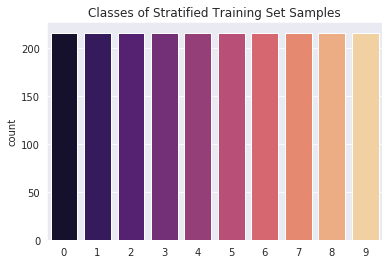

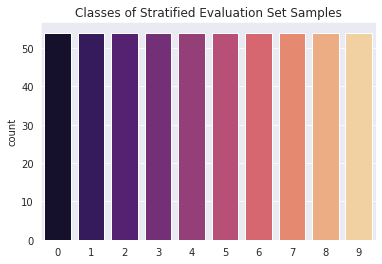

In [8]:
sns.set_style('darkgrid')
#fig, axes = plt.subplots(1, 2)
sns.countplot(x=y_train, palette = 'magma')#, ax=axes[0])
#sns.countplot(y_train, palette = 'magma', ax= axes[1])
plt.title("Classes of Stratified Training Set Samples")
plt.show()
print("\n")

sns.set_style('darkgrid')
#fig, axes = plt.subplots(1, 2)
sns.countplot(x=y_dev, palette = 'magma')#, ax=axes[0])
#sns.countplot(y_train, palette = 'magma', ax= axes[1])
plt.title("Classes of Stratified Evaluation Set Samples")
plt.show()


### Apply StandardScaling on our data for better performance

In [9]:
print("If using X_train to calculate normalization statistics")
scale_fn = make_scale_fn(X_train)
X_train = scale_fn(X_train)
X_dev = scale_fn(X_dev)
X_test = scale_fn(X_test)

If using X_train to calculate normalization statistics
Normalization will be performed using mean: [-519.04016977   62.06749573   19.0877713     9.67797146  -19.16009936
  -10.86785319  -14.35801505   -7.80066499  -11.9068304    -4.14759392
   -6.66580162   -4.35981593   -6.93628383]
Normalization will be performed using std: [153.12611669  52.31074756  36.61860033  29.66706359  24.90808089
  23.29788466  18.58627443  18.14916101  15.74104656  13.18785806
  14.82458446  12.66559393  12.01130099]


## Task 10 - GMM-HMM Initialization

Create GMM-HMM model per each digit for training set

In [ ]:
# For all digits

ds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
train_data = [
        [X_train[indx] for indx in np.argwhere(np.array(y_train)==d).flatten()]
    for d in tqdm(ds, "Grouping data for each digit...")
]
train_bag = [np.vstack(train_d) for train_d in train_data]


Grouping data for each digit...: 100%|██████████| 10/10 [00:00<00:00, 1618.17it/s]


In [ ]:
print(train_data[0][0].shape)
print(train_bag[0].shape)

(25, 13)
(7444, 13)


We define transition, start, end matrices

In [ ]:
n_states = 4 # the number of HMM states
n_mixtures = 4 # the number of Gaussians
gmm = True # whether to use GMM or plain Gaussian

# transition probabilities
trans_mat = np.zeros((n_states, n_states))# your transition matrix
starts = np.zeros(n_states)# your starting probability matrix
ends = np.zeros(n_states) # your ending probability matrix

trans_mat[-1][-1] = 1.0
for i in range(n_states-1):
  trans_mat[i][i] = 0.5 # equal probs for moving to the next state or staying in the same 
  trans_mat[i][i+1] = 0.5

starts[0] = 1.0 # your starting probability matrix
ends[-1] = 1.0 # your ending probability matrix             
# ends = None # your ending probability matrix 


In [ ]:
print(type(train_bag[0][0][0]))

<class 'numpy.float64'>


We compute emission probabilities

In [ ]:
models = []
for d in ds:
  dists = [] # list of probability distributions(emission) for the HMM states
  for i in range(n_states):
    if gmm:
        g = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, n_mixtures, train_bag[d])
    else:
        g = MultivariateGaussianDistribution.from_samples(train_bag[d])
    dists.append(g)

      # Define the GMM-HMM
  model = HiddenMarkovModel.from_matrix(\
                                        trans_mat, dists, starts, ends, \
                                        state_names=['s{}'.format(i)\
                                                    for i in range(n_states)])
  models.append(model)


## Task 11 - GMM-HMM Training

Train our models for specific number of states, num_components

In [ ]:
for indx, model in enumerate(models):

  # Fit the model
  model.fit(train_data[indx].copy(), max_iterations=2)
  # your data: must be a Python list that contains: 2D lists with the sequences (so its dimension would be num_sequences x seq_length x feature_dimension)
  # But be careful, it is not a numpy array, it is a Python list (so each sequence can have different length)


## Task 12 - Validation / Optimization

### Validation on DevSet

In [ ]:
print(X_dev[0].shape)

(36, 13)


In [ ]:
# Predict a sequence
pred = []
for sample in X_dev: # a sample sequence
  logs = np.zeros(len(ds))

  for i, model in enumerate(models):
    logs[i] = model.viterbi(sample)[0]# Run viterbi algorithm and return log-probability
  
  pred.append(np.argmax(logs))  


In [ ]:
print(accuracy_score(y_dev, pred))

0.9851851851851852


### Optimization with Otpuna by Accuracy Metric

#### Define Classifier

In [ ]:
class HMM(BaseEstimator, ClassifierMixin):
    # Hidden Markov Model using Gaussian Mixtures Model
    # Labels are supposed to be in range[0, len(n_labels)]
    def __init__(self, n_states, n_components, max_iter, gmm=True, max_d=10):
        self.models = []
        self.n_states = n_states
        self.n_components = n_components
        self.max_iter = max_iter
        self.gmm = gmm
        self.ds = np.arange(max_d)
        
    def fit(self, X, y=None):
                
        # Bag of MFCCs for each digit
        X_bag = [np.vstack(x) for x in X]
        
        # transition probabilities
        trans_mat = np.zeros((self.n_states, self.n_states))# your transition matrix
        starts = np.zeros(self.n_states)# your starting probability matrix
        ends = np.zeros(self.n_states) # your ending probability matrix

        trans_mat[-1][-1] = 1.0
        for i in range(self.n_states-1):
          trans_mat[i][i] = 0.5 # equal probs for moving to the next state or staying in the same 
          trans_mat[i][i+1] = 0.5

        starts[0] = 1.0 # # absolute certainty for model's starting from the last state
        ends[-1] = 1.0 # absolute certainty for model's ending up to the last state

        for d in self.ds:
            dists = [] # list of probability distributions(emission) for the HMM states
            for i in range(self.n_states):
              if self.gmm:
                  g = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, self.n_components, X_bag[d])
              else:
                  g = MultivariateGaussianDistribution.from_samples(X_bag[d])
              dists.append(g)

                # Define the GMM-HMM
            model = HiddenMarkovModel.from_matrix(\
                                                  trans_mat, dists, starts, ends, \
                                                  state_names=['s{}'.format(i)\
                                                              for i in range(self.n_states)])
            self.models.append(model)

        for indx, model in enumerate(self.models):

            # Fit the model
            model.fit(X[indx].copy(), max_iterations=self.max_iter)
            # your data: must be a Python list that contains: 2D lists with the sequences (so its dimension would be num_sequences x seq_length x feature_dimension)
            # But be careful, it is not a numpy array, it is a Python list (so each sequence can have different length)

        return self
    
        
    def predict(self, X):

        # Predict a sequence
        pred = []
        for sample in X: # a sample sequence
          logs = np.zeros(len(self.ds))

          for i, model in enumerate(self.models):
            logs[i] = model.viterbi(sample)[0]# Run viterbi algorithm and return log-probability
          
          pred.append(np.argmax(logs))  
            
        return pred

    
    def score(self, X, y):
        pred = self.predict(X)
        return accuracy_score(y, pred)

In [ ]:
# Dummy example, just for being sure it's working
h = HMM(n_states=4, n_components=4, max_iter=4)
h.fit(train_data)

HMM(gmm=True, max_d=None, max_iter=4, n_components=4, n_states=4)

In [ ]:
print(h.score(X_dev, y_dev))

0.9944444444444445


#### Define objective function

In [ ]:
def objective(trial):

    #Scaler
    # scaler = StandardScaler() # We have already scaled our data 
    
    # HMM-GMM
    n_states = trial.suggest_int('n_states', 1, 4)
    n_components = trial.suggest_int('n_components', 2, 5)
    max_iter = trial.suggest_int('max_iter', 200, 400, 100)
   
    clf = HMM(n_states=n_states, n_components=n_components, max_iter=max_iter)
    clf.fit(train_data)
    
    return clf.score(X_dev, y_dev)

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20) # for final presentation it must be set to 100 and higher

[I 2021-12-18 11:46:06,425] A new study created in memory with name: no-name-4800130e-bace-4945-a445-09dc747f7f9a


TypeError: ignored

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: ignored

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'
[I 2021-12-18 11:51:59,774] Trial 0 finished with value: 0.9907407407407407 and parameters: {'n_states': 4, 'n_components': 5, 'max_iter': 200}. Best is trial 0 with value: 0.9907407407407407.
[I 2021-12-18 11:52:23,882] Trial 1 finished with value: 0.9351851851851852 and parameters: {'n_states': 1, 'n_components': 2, 'max_iter': 200}. Best is trial 0 with value: 0.9907407407407407.
[I 2021-12-18 11:53:12,327] Trial 2 finished with value: 0.975925925925926 and parameters: {'n_states':

TypeError: ignored

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: ignored

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'
[I 2021-12-18 12:01:33,283] Trial 4 finished with value: 0.9981481481481481 and parameters: {'n_states': 3, 'n_components': 5, 'max_iter': 300}. Best is trial 4 with value: 0.9981481481481481.
[I 2021-12-18 12:03:50,240] Trial 5 finished with value: 0.9907407407407407 and parameters: {'n_states': 4, 'n_components': 2, 'max_iter': 200}. Best is trial 4 with value: 0.9981481481481481.
[I 2021-12-18 12:04:45,113] Trial 6 finished with value: 0.9796296296296296 and parameters: {'n_states'

TypeError: ignored

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: ignored

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'
[I 2021-12-18 12:19:23,710] Trial 9 finished with value: 0.9944444444444445 and parameters: {'n_states': 4, 'n_components': 5, 'max_iter': 400}. Best is trial 4 with value: 0.9981481481481481.
[I 2021-12-18 12:24:01,905] Trial 10 finished with value: 0.9925925925925926 and parameters: {'n_states': 3, 'n_components': 4, 'max_iter': 300}. Best is trial 4 with value: 0.9981481481481481.
[I 2021-12-18 12:26:29,362] Trial 11 finished with value: 0.9944444444444445 and parameters: {'n_state

TypeError: ignored

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: ignored

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: ignored

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: ignored

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'
[I 2021-12-18 12:42:52,615] Trial 16 finished with value: 0.9981481481481481 and parameters: {'n_states': 3, 'n_components': 5, 'max_iter': 300}. Best is trial 4 with value: 0.9981481481481481.


TypeError: ignored

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: ignored

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: ignored

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: ignored

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: ignored

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: ignored

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: ignored

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: ignored

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: ignored

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'
[I 2021-12-18 12:46:39,796] Trial 17 finished with value: 0.9888888888888889 and parameters: {'n_states': 4, 'n_components': 4, 'max_iter': 200}. Best is trial 4 with value: 0.9981481481481481.
[I 2021-12-18 12:49:25,920] Trial 18 finished with value: 0.9907407407407407 and parameters: {'n_states': 3, 'n_components': 3, 'max_iter': 400}. Best is trial 4 with value: 0.9981481481481481.
[I 2021-12-18 12:52:53,089] Trial 19 finished with value: 0.9907407407407407 and parameters: {'n_stat

In [ ]:
params = study.best_trials[0].params
print(params)

with open('./best_hmm.pickle', 'wb') as handle:
  pickle.dump(study, handle, protocol=pickle.HIGHEST_PROTOCOL)


{'n_states': 3, 'n_components': 5, 'max_iter': 300}


#### Make Instance using the optimal parameters / Testing

In [ ]:
print("Best params for HMM:")

with open('./best_hmm.pickle', 'rb') as handle:
  study_hmm  = pickle.load(handle)

best_params = study_hmm.best_trials[0].params
print(best_params)

hmm = HMM(n_states=best_params['n_states'], n_components=best_params['n_components'], max_iter=best_params['max_iter'])
hmm.fit(train_data)
dev_pred = hmm.predict(X_dev)
test_pred = hmm.predict(X_test)

print("Testset accuracy score:\t", hmm.score(X_test, y_test))

Best params for HMM:
{'n_states': 3, 'n_components': 5, 'max_iter': 300}
Testset accuracy score:	 0.99


## Task 13 Confusion Matrices for Dev-Test Set

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        54
           1       1.00      1.00      1.00        54
           2       0.98      1.00      0.99        54
           3       0.98      0.94      0.96        54
           4       1.00      1.00      1.00        54
           5       1.00      1.00      1.00        54
           6       1.00      0.98      0.99        54
           7       0.98      1.00      0.99        54
           8       1.00      1.00      1.00        54
           9       1.00      1.00      1.00        54

    accuracy                           0.99       540
   macro avg       0.99      0.99      0.99       540
weighted avg       0.99      0.99      0.99       540

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        30
           1       0.97      1.00      0.98        30
           2       1.00      1.00      1.00        30
           3       1.00 

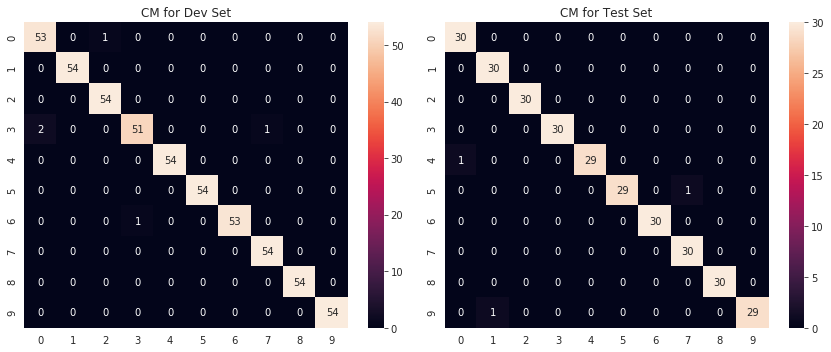

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

for X, y, pred, ax, title in zip((X_dev, X_test), (y_dev, y_test), (dev_pred, test_pred), axes.flatten(), ('CM for Dev Set', 'CM for Test Set')):
  ### Fit model to get the predictions ###

  print(classification_report(y, pred))

  cm = confusion_matrix(np.array(y), np.array(pred))
  sns.heatmap(cm, ax=ax, annot=True)
  ax.title.set_text(title)

plt.tight_layout()  
plt.show()

## Task 14 - LSTM - Classifier

#### Classes Implementation

In [10]:
class FrameLevelDataset(Dataset):
    def __init__(self, feats, labels):
        """
            feats: Python list of numpy arrays that contain the sequence features.
                   Each element of this list is a numpy array of shape seq_length x feature_dimension
            labels: Python list that contains the label for each sequence (each label must be an integer)
        """
        self.lengths = [len(seq) for seq in feats] # Find the lengths 

        self.feats, self.longest_seq = self.zero_pad_and_stack(feats)
        if isinstance(labels, (list, tuple)):
            self.labels = np.array(labels).astype('int64')

    def zero_pad_and_stack(self, X):
        """
            This function performs zero padding on a list of features and forms them into a numpy 3D array
            returns
                padded: a 3D numpy array of shape num_sequences x max_sequence_length x feature_dimension
        """
        # get the length of each sentence
        seq_lens = [len(seq) for seq in X]

        # create an empty matrix with padding tokens
        longest_seq = max(seq_lens)

        batch_size = len(X)
        feat_dim = X[0].shape[1]

        padded_X = np.zeros((batch_size, longest_seq, feat_dim))

        # copy over the actual sequences
        for i, x_len in enumerate(seq_lens):
          sequence = X[i]
          padded_X[i, :x_len] = sequence[:x_len]

        return padded_X, longest_seq

    def __getitem__(self, item):
        return self.feats[item], self.labels[item], self.lengths[item]

    def __len__(self):
        return len(self.feats)


In [11]:
class ClfLSTM(nn.Module):
    def __init__(self, input_dim, rnn_size, output_dim, num_layers, bidirectional=False, dropout=None, pack_padded_sequence=False):
        super(ClfLSTM, self).__init__()
        self.bidirectional = bidirectional
        self.feature_size = rnn_size * 2 if self.bidirectional else rnn_size
        self.num_layers = num_layers
        self.pack_padded_sequence = pack_padded_sequence
        #define the lstm
        self.lstm = nn.LSTM(input_dim, self.feature_size, self.num_layers, batch_first=True)

        #Define dropout layer(because of num_layers==1, we are setting a distinct dropout layer after lstm)
        self.dropout = nn.Dropout(dropout) if dropout is not None else None
        #define a non-linear transformation of the representations
        self.output = nn.Linear(self.feature_size, output_dim)
        self.double()


    ## TODO: I may have to implement the init_hidden() for initializing h0
    #def init_hidden(self): . . .

    def forward(self, x, lengths):
        """ 
            x : 3D numpy array of dimension N x L x D
                N: batch index
                L: sequence index
                D: feature index
            lengths: N x 1
         """
        #define batch_size and max_length
        batch_size, max_length, _ = x.shape

        # Improving Training Complexity (Bonus)
        if self.pack_padded_sequence:
          # Sort by length, pass through LSTM layer as pack_padded_sequence and retieve initial ordering
          # Sort by length (keep idx)
          sorted_lengths, idx_sort = np.sort(lengths)[::-1], np.argsort(-lengths)
          idx_unsort = np.argsort(idx_sort)

          # x = x.index_select(0, Variable(idx_sort)) # i may have to use it
          x = x.index_select(0, idx_sort)

          # Handling padding in Recurrent Networks
          x = nn.utils.rnn.pack_padded_sequence(x, sorted_lengths.tolist(), batch_first=True) 
          ht, _ = self.lstm(x)
          ht, _ = nn.utils.rnn.pad_packed_sequence(ht, batch_first=True) 

          # Un-sort by length
          ht = ht.index_select(0, idx_unsort)

        # ht, _ = self.lstm(X, (h_0, c_0), batch_first=True) ## for another verion
        else:
          ht, _ = self.lstm(x)

        # You must have all of the outputs of the LSTM, but you need only the last one (that does not exceed the sequence length)
        # To get it use the last_timestep method
        # Then pass it through the remaining network

        # Given implementation
        last_step = self.last_timestep(ht, lengths, self.bidirectional)

        ## Our implementation for pick the last not exceed the max_length
        ## For bidirectional = True, it doesn't work
        # last_step = torch.zeros(batch_size, self.feature_size).float()
        # for i in range(lengths.shape[0]):
        #     last = lengths[i] - 1 if lengths[i] <= max_length else max_length - 1
        #     last_step[i] = ht[i, last, :]

        logits = self.dropout(self.output(last_step)) if self.dropout is not None else self.output(last_step)
        return logits

    def last_timestep(self, outputs, lengths, bidirectional=False):
        """
            Returns the last output of the LSTM taking into account the zero padding
        """
        if bidirectional:
            forward, backward = self.split_directions(outputs)
            last_forward = self.last_by_index(forward, lengths)
            last_backward = backward[:, 0, :]
            # Concatenate and return - maybe add more functionalities like average
            return torch.cat((last_forward, last_backward), dim=-1)

        else:
            return self.last_by_index(outputs, lengths)

    @staticmethod
    def split_directions(outputs):
        direction_size = int(outputs.size(-1) / 2)
        forward = outputs[:, :, :direction_size]
        backward = outputs[:, :, direction_size:]
        return forward, backward

    @staticmethod
    def last_by_index(outputs, lengths):
        # Index of the last output for each sequence.
        idx = (lengths - 1).view(-1, 1).expand(outputs.size(0),
                                               outputs.size(2)).unsqueeze(1)
        return outputs.gather(1, idx).squeeze()

In [12]:
class EarlyStopping():  #class for the early stopping reguralization
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=3, verbose=True, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 3
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.best = {}
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.test_loss_min = np.Inf
        self.delta = delta  #definition of the minimum tolerance

    def __call__(self, accuracy, f1, recall, train_loss, test_loss, epoch):

        score = -test_loss

        if self.best_score is None: #check if it is the first epoch
            self.best_score = score
            self.best['epoch'] = epoch
            self.best['loss'] = [train_loss, test_loss]
            self.best['accuracy'] = [accuracy[0, epoch-1], accuracy[1, epoch-1]]
            self.best['f1'] = [f1[0, epoch-1], f1[1, epoch-1]]
            self.best['recall'] = [recall[0, epoch-1], recall[1, epoch-1]]
            
            if self.verbose:
                print(f'Test loss decreased ({self.test_loss_min:.6f} --> {test_loss:.6f}).  Saving model ...')
            self.test_loss_min = test_loss
        elif score < self.best_score + self.delta:  #if there is no advance then increase counter
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:   #if counter == patience then stop
                self.early_stop = True
        else:
            self.best_score = score #else save the best model till now
            if self.verbose:
                print(f'Test loss decreased ({self.test_loss_min:.6f} --> {test_loss:.6f}).  Saving model ...')
            self.counter = 0
            self.best['epoch'] = epoch
            self.best['loss'] = [train_loss, test_loss]
            self.best['accuracy'] = [accuracy[0, epoch-1], accuracy[1, epoch-1]]
            self.best['f1'] = [f1[0, epoch-1], f1[1, epoch-1]]
            self.best['recall'] = [recall[0, epoch-1], recall[1, epoch-1]]
            self.test_loss_min = test_loss

    def stopping(self):
        return self.early_stop

    def get_best(self):
        return self.best


#### Pipeline Functions

In [13]:
def progress(loss, epoch, batch, batch_size, dataset_size):
    """
    Print the progress of the training for each epoch
    """
    batches = math.ceil(float(dataset_size) / batch_size)
    count = batch * batch_size
    bar_len = 40
    filled_len = int(round(bar_len * count / float(dataset_size)))

    bar = '=' * filled_len + '-' * (bar_len - filled_len)

    status = 'Epoch {}, Loss: {:.4f}'.format(epoch, loss)
    _progress_str = "\r \r [{}] ...{}".format(bar, status)
    sys.stdout.write(_progress_str)
    sys.stdout.flush()

    if batch == batches:
        print()

In [14]:
def train_lstm(_epoch, dataloader, model, loss_function, optimizer):
    # IMPORTANT: switch to train mode
    # enable regularization layers, such as Dropout
    model.train()
    running_loss = 0.0
    # obtain the model's device ID
    device = next(model.parameters()).device
    for index, batch in enumerate(dataloader, 1):

        inputs, labels, lengths = batch

        # move the batch tensors to the right device
        inputs, labels, lengths = inputs.to(device), labels.to(device), lengths.to(device)  # EX9
        # Step 1 - zero the gradients
        # Remember that PyTorch accumulates gradients.
        # We need to clear them out before each batch!
        model.zero_grad()  # EX9
        
        # Step 2 - forward pass: y' = model(x)
        outputs = model(inputs, lengths)  # EX9
        # Step 3 - compute loss: L = loss_function(y, y')
        loss = loss_function(outputs, labels)  # EX9
        # Step 4 - backward pass: compute gradient wrt model parameters
        
        loss.backward() # EX9
        # Step 5 - update weights
        optimizer.step()  # EX9
        running_loss += loss.data.item()

        progress(loss=loss.data.item(),
                 epoch=_epoch,
                 batch=index,
                 batch_size=dataloader.batch_size,
                 dataset_size=len(dataloader.dataset))
        


In [15]:
def eval_lstm(dataloader, model, loss_function):
    # IMPORTANT: switch to eval mode
    # disable regularization layers, such as Dropout
    model.eval()
    running_loss = 0.0

    y_pred = []  # the predicted labels
    y = []  # the gold labels

    # obtain the model's device ID
    device = next(model.parameters()).device

    # IMPORTANT: in evaluation mode, we don't want to keep the gradients
    # so we do everything under torch.no_grad()
    with torch.no_grad():
        for index, batch in enumerate(dataloader, 1):
            # get the inputs (batch)
            inputs, labels, lengths = batch

            # Step 1 - move the batch tensors to the right device
            inputs, labels, lengths = inputs.to(device), labels.to(device), lengths.to(device)  # EX9

            # Step 2 - forward pass: y' = model(x)
            outputs = model(inputs, lengths) # EX9

            # Step 3 - compute loss.
            # We compute the loss only for inspection (compare train/test loss)
            # because we do not actually backpropagate in test time

            loss = loss_function(outputs, labels)  # EX9
        
            # Step 4 - make predictions (class = argmax of posteriors)
        
            val, pred = outputs.max(1) # argmax since output is a prob distribution  # EX9

            # Step 5 - collect the predictions, gold labels and batch loss
            tags = []
      
            y += list(labels)
            y_pred += list(pred) # EX9
            running_loss += loss.data.item()
    return running_loss / index, y, y_pred


In [16]:
def plot_stats(losses, accuracy, f1, recall, epochs, ep, best=None):
  
  figure, axes = plt.subplots(nrows=2, ncols=2, figsize = (20,5))
  titles = ['Loss', 'Accuracy Score', 'F1 Score', 'Recall Score']
  functions = [losses, accuracy, f1, recall]
  best_keys = ['loss', 'accuracy', 'f1', 'recall']
  descrs = ['Loss', 'Accuracy Score', 'F1 Score', 'Recall Score']

  for ax, title, function, key, descr in zip(axes.flatten(), titles, functions, best_keys, descrs):

    ax.plot(epochs, function[0,:ep], label="Train Set")
    ax.plot(epochs, function[1,:ep], label="Dev Set")

    if best is not None:
      ax.plot(best['epoch'], best[key][0], marker="o",color="red", label=f"Best Model's {descr} for the Train Set")
      ax.plot(best['epoch'], best[key][1], marker="o",color="green", label=f"Best Model's {descr} for the Dev Set")
      
    ax.set_title(title)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Values')
    ax.grid()
    ax.legend()

  plt.tight_layout()
  plt.show()

In [17]:
def main(net, optimizer, criterion, train_loader, dev_loader, EPOCHS, net_name=None, PATIENCE=None):
  #############################################################################
  # Training Pipeline
  #############################################################################
  losses = np.zeros((2,EPOCHS))
  accuracy = np.zeros((2,EPOCHS))
  f1 = np.zeros((2,EPOCHS))
  recall = np.zeros((2,EPOCHS))
  total = 0
  base = time.time()
  early = EarlyStopping(patience=PATIENCE) if PATIENCE is not None else None
  ep = 0
  E_loss = np.inf

  for epoch in tqdm(range(1, EPOCHS + 1)):
      ep += 1
      now = time.time()
      
      # train the model for one epoch
      train_lstm(epoch, train_loader, net, criterion, optimizer)
      # evaluate the performance of the model, on both data sets
      train_loss, y_train_gold, y_train_pred = eval_lstm(train_loader, net, criterion)
      losses[0, epoch-1] = train_loss

      print(f"Statistics for the Train Set")

      accuracy[0, epoch-1] = accuracy_score(y_train_gold, y_train_pred)
      print(f'\t Epoch: {epoch} \t Accuracy Score: {accuracy_score(y_train_gold, y_train_pred)}')
      f1[0, epoch-1] = f1_score(y_train_gold, y_train_pred, average='macro')
      print(f'\t Epoch: {epoch} \t f1 Score: {f1[0, epoch-1]}')
      recall[0, epoch-1] = recall_score(y_train_gold, y_train_pred, average='macro')
      print(f'\t Epoch: {epoch} \t recall Score: {recall[0, epoch-1]}')

      
      test_loss, y_test_gold, y_test_pred = eval_lstm(dev_loader, net, criterion)
      
      if net_name is not None and E_loss > test_loss:
          E_loss = test_loss
          with open(f'./best_{net_name}.pickle', 'wb') as handle:  # Use pickle files to save our models
            pickle.dump(net, handle, protocol=pickle.HIGHEST_PROTOCOL)

      losses[1, epoch-1] = test_loss
      print(f"Statistics for the Dev Set")
      print(f'\t Epoch: {epoch} \t loss: {losses[1, epoch-1]}')

      accuracy[1, epoch-1] = accuracy_score(y_test_gold, y_test_pred)
      print(f'\t Epoch: {epoch} \t Accuracy Score: {accuracy[1, epoch-1]}')
      f1[1, epoch-1] = f1_score(y_test_gold, y_test_pred, average='macro')
      print(f'\t Epoch: {epoch} \t f1 Score: {f1[1, epoch-1]}')
      recall[1, epoch-1] = recall_score(y_test_gold, y_test_pred, average='macro')
      print(f'\t Epoch: {epoch} \t recall Score: {recall[1, epoch-1]}')

      if early is not None:
        early.__call__(accuracy, f1, recall, train_loss, test_loss, epoch)   #call the object early for checking the advance
        if early.stopping() == True:    #if true then stop the training to avoid overfitting
                break

      tm = time.time() - now
      total += tm
      print("Epoch total time", tm)

  print("Training total time", total)

  epochs = np.linspace(1, ep, ep)
  best = early.get_best() if early is not None else None

  # Plot our Study's Result
  plot_stats(losses, accuracy, f1, recall, epochs, ep, best=best)



In [18]:
def plot_conf_mat(y,pred,model):
  fig = plt.figure(figsize=(6,5))
  cm = confusion_matrix(np.array(y), np.array(pred))
  sns.heatmap(cm, annot=True)
  plt.title(f'Confusion Matrix for {model}')
  plt.tight_layout()  
  plt.show()

#### Define General Training Parameters

In [19]:
# Define training parameters 
BATCH_SIZE = 128
EPOCHS = 30
ETA = 1e-2
INPUT_SIZE = 13
OUTPUT_SIZE = 10
HIDDEN_LAYER = 50
NUM_LAYERS = 1

# Seperate to train, dev
# Data Sets have already been scaled w.r.t. train set
train_set = FrameLevelDataset(X_train, y_train)
dev_set = FrameLevelDataset(X_dev, y_dev)
test_set = FrameLevelDataset(X_test, y_test)

# Create dataloaders
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

#Define out LossFunction
criterion = nn.CrossEntropyLoss()

#### SubTasks 1-4 - Basic Training

###### Training of BasicLSTM

  0%|          | 0/30 [00:00<?, ?it/s]

 [========================================] ...Epoch 1, Loss: 1.1848
Statistics for the Train Set
	 Epoch: 1 	 Accuracy Score: 0.6583333333333333
	 Epoch: 1 	 f1 Score: 0.6516040997927982
	 Epoch: 1 	 recall Score: 0.6583333333333333


  3%|▎         | 1/30 [00:06<02:57,  6.12s/it]

Statistics for the Dev Set
	 Epoch: 1 	 loss: 1.1052828006426272
	 Epoch: 1 	 Accuracy Score: 0.6518518518518519
	 Epoch: 1 	 f1 Score: 0.6482159986752227
	 Epoch: 1 	 recall Score: 0.6518518518518519
Epoch total time 6.116329908370972
 [========================================] ...Epoch 2, Loss: 0.8017
Statistics for the Train Set
	 Epoch: 2 	 Accuracy Score: 0.7810185185185186
	 Epoch: 2 	 f1 Score: 0.7812482813241678
	 Epoch: 2 	 recall Score: 0.7810185185185184


  7%|▋         | 2/30 [00:11<02:43,  5.84s/it]

Statistics for the Dev Set
	 Epoch: 2 	 loss: 0.7001531026980303
	 Epoch: 2 	 Accuracy Score: 0.7555555555555555
	 Epoch: 2 	 f1 Score: 0.7561563046460197
	 Epoch: 2 	 recall Score: 0.7555555555555555
Epoch total time 5.187999248504639
 [========================================] ...Epoch 3, Loss: 0.5969
Statistics for the Train Set
	 Epoch: 3 	 Accuracy Score: 0.8574074074074074
	 Epoch: 3 	 f1 Score: 0.8582236246333445
	 Epoch: 3 	 recall Score: 0.8574074074074074


 10%|█         | 3/30 [00:16<02:32,  5.64s/it]

Statistics for the Dev Set
	 Epoch: 3 	 loss: 0.5228917090101597
	 Epoch: 3 	 Accuracy Score: 0.8518518518518519
	 Epoch: 3 	 f1 Score: 0.8530157239298779
	 Epoch: 3 	 recall Score: 0.8518518518518519
Epoch total time 5.19003963470459
 [========================================] ...Epoch 4, Loss: 0.3131
Statistics for the Train Set
	 Epoch: 4 	 Accuracy Score: 0.9185185185185185
	 Epoch: 4 	 f1 Score: 0.9186256151649994
	 Epoch: 4 	 recall Score: 0.9185185185185185


 13%|█▎        | 4/30 [00:21<02:23,  5.51s/it]

Statistics for the Dev Set
	 Epoch: 4 	 loss: 0.31266120721841695
	 Epoch: 4 	 Accuracy Score: 0.9018518518518519
	 Epoch: 4 	 f1 Score: 0.9021273857271266
	 Epoch: 4 	 recall Score: 0.9018518518518517
Epoch total time 5.188220024108887
 [========================================] ...Epoch 5, Loss: 0.2330
Statistics for the Train Set
	 Epoch: 5 	 Accuracy Score: 0.9486111111111111
	 Epoch: 5 	 f1 Score: 0.9487242624961505
	 Epoch: 5 	 recall Score: 0.9486111111111111
Statistics for the Dev Set
	 Epoch: 5 	 loss: 0.2135480480810838
	 Epoch: 5 	 Accuracy Score: 0.937037037037037
	 Epoch: 5 	 f1 Score: 0.9373397297955222


 17%|█▋        | 5/30 [00:26<02:15,  5.42s/it]

	 Epoch: 5 	 recall Score: 0.937037037037037
Epoch total time 5.223141670227051
 [========================================] ...Epoch 6, Loss: 0.0821
Statistics for the Train Set
	 Epoch: 6 	 Accuracy Score: 0.9444444444444444
	 Epoch: 6 	 f1 Score: 0.9446153407204211
	 Epoch: 6 	 recall Score: 0.9444444444444444


 20%|██        | 6/30 [00:32<02:08,  5.36s/it]

Statistics for the Dev Set
	 Epoch: 6 	 loss: 0.2515071029941678
	 Epoch: 6 	 Accuracy Score: 0.9333333333333333
	 Epoch: 6 	 f1 Score: 0.9328770017667937
	 Epoch: 6 	 recall Score: 0.9333333333333332
Epoch total time 5.202446460723877
 [========================================] ...Epoch 7, Loss: 0.1967
Statistics for the Train Set
	 Epoch: 7 	 Accuracy Score: 0.9740740740740741
	 Epoch: 7 	 f1 Score: 0.974122280093377
	 Epoch: 7 	 recall Score: 0.9740740740740741
Statistics for the Dev Set
	 Epoch: 7 	 loss: 0.15376180097449507
	 Epoch: 7 	 Accuracy Score: 0.9555555555555556
	 Epoch: 7 	 f1 Score: 0.9554027983021415


 23%|██▎       | 7/30 [00:37<02:02,  5.32s/it]

	 Epoch: 7 	 recall Score: 0.9555555555555557
Epoch total time 5.238662242889404
 [========================================] ...Epoch 8, Loss: 0.1170
Statistics for the Train Set
	 Epoch: 8 	 Accuracy Score: 0.9800925925925926
	 Epoch: 8 	 f1 Score: 0.9801727534449766
	 Epoch: 8 	 recall Score: 0.9800925925925925
Statistics for the Dev Set
	 Epoch: 8 	 loss: 0.11276356035889376
	 Epoch: 8 	 Accuracy Score: 0.9629629629629629
	 Epoch: 8 	 f1 Score: 0.9630306808077373


 27%|██▋       | 8/30 [00:42<01:56,  5.30s/it]

	 Epoch: 8 	 recall Score: 0.962962962962963
Epoch total time 5.2602574825286865
 [========================================] ...Epoch 9, Loss: 0.0487
Statistics for the Train Set
	 Epoch: 9 	 Accuracy Score: 0.987037037037037
	 Epoch: 9 	 f1 Score: 0.9870456462655145
	 Epoch: 9 	 recall Score: 0.987037037037037
Statistics for the Dev Set
	 Epoch: 9 	 loss: 0.18491806939280603
	 Epoch: 9 	 Accuracy Score: 0.9555555555555556
	 Epoch: 9 	 f1 Score: 0.9555223004755715


 30%|███       | 9/30 [00:47<01:50,  5.28s/it]

	 Epoch: 9 	 recall Score: 0.9555555555555555
Epoch total time 5.213128089904785
 [========================================] ...Epoch 10, Loss: 0.0283
Statistics for the Train Set
	 Epoch: 10 	 Accuracy Score: 0.9814814814814815
	 Epoch: 10 	 f1 Score: 0.9814885069613473
	 Epoch: 10 	 recall Score: 0.9814814814814813


 33%|███▎      | 10/30 [00:53<01:45,  5.26s/it]

Statistics for the Dev Set
	 Epoch: 10 	 loss: 0.15815360526052147
	 Epoch: 10 	 Accuracy Score: 0.9537037037037037
	 Epoch: 10 	 f1 Score: 0.9536959330936616
	 Epoch: 10 	 recall Score: 0.9537037037037036
Epoch total time 5.2107994556427
 [========================================] ...Epoch 11, Loss: 0.0478
Statistics for the Train Set
	 Epoch: 11 	 Accuracy Score: 0.975925925925926
	 Epoch: 11 	 f1 Score: 0.9757878375058195
	 Epoch: 11 	 recall Score: 0.9759259259259258


 37%|███▋      | 11/30 [00:58<01:39,  5.24s/it]

Statistics for the Dev Set
	 Epoch: 11 	 loss: 0.2393941142335046
	 Epoch: 11 	 Accuracy Score: 0.9555555555555556
	 Epoch: 11 	 f1 Score: 0.9556042212490471
	 Epoch: 11 	 recall Score: 0.9555555555555557
Epoch total time 5.179723262786865
 [========================================] ...Epoch 12, Loss: 0.0742
Statistics for the Train Set
	 Epoch: 12 	 Accuracy Score: 0.9875
	 Epoch: 12 	 f1 Score: 0.9875378807101424
	 Epoch: 12 	 recall Score: 0.9875


 40%|████      | 12/30 [01:03<01:33,  5.22s/it]

Statistics for the Dev Set
	 Epoch: 12 	 loss: 0.17172872707467485
	 Epoch: 12 	 Accuracy Score: 0.9592592592592593
	 Epoch: 12 	 f1 Score: 0.9591467527862101
	 Epoch: 12 	 recall Score: 0.9592592592592594
Epoch total time 5.180001735687256
 [========================================] ...Epoch 13, Loss: 0.0638
Statistics for the Train Set
	 Epoch: 13 	 Accuracy Score: 0.9856481481481482
	 Epoch: 13 	 f1 Score: 0.9856845155206084


 43%|████▎     | 13/30 [01:08<01:29,  5.25s/it]

	 Epoch: 13 	 recall Score: 0.985648148148148
Statistics for the Dev Set
	 Epoch: 13 	 loss: 0.11941287338844064
	 Epoch: 13 	 Accuracy Score: 0.9537037037037037
	 Epoch: 13 	 f1 Score: 0.9536258028957544
	 Epoch: 13 	 recall Score: 0.9537037037037036
Epoch total time 5.329336166381836
 [========================================] ...Epoch 14, Loss: 0.0496
Statistics for the Train Set
	 Epoch: 14 	 Accuracy Score: 0.9893518518518518
	 Epoch: 14 	 f1 Score: 0.9893489585631698
	 Epoch: 14 	 recall Score: 0.9893518518518519


 47%|████▋     | 14/30 [01:13<01:23,  5.23s/it]

Statistics for the Dev Set
	 Epoch: 14 	 loss: 0.14406769509056247
	 Epoch: 14 	 Accuracy Score: 0.9592592592592593
	 Epoch: 14 	 f1 Score: 0.9592597675616543
	 Epoch: 14 	 recall Score: 0.9592592592592594
Epoch total time 5.179488897323608
 [========================================] ...Epoch 15, Loss: 0.0236
Statistics for the Train Set
	 Epoch: 15 	 Accuracy Score: 0.9921296296296296
	 Epoch: 15 	 f1 Score: 0.9921182276421998
	 Epoch: 15 	 recall Score: 0.9921296296296296


 50%|█████     | 15/30 [01:19<01:18,  5.23s/it]

Statistics for the Dev Set
	 Epoch: 15 	 loss: 0.11886243305538594
	 Epoch: 15 	 Accuracy Score: 0.9648148148148148
	 Epoch: 15 	 f1 Score: 0.9650207327998114
	 Epoch: 15 	 recall Score: 0.9648148148148149
Epoch total time 5.205802917480469
 [========================================] ...Epoch 16, Loss: 0.0476
Statistics for the Train Set
	 Epoch: 16 	 Accuracy Score: 0.9958333333333333
	 Epoch: 16 	 f1 Score: 0.9958391226221593
	 Epoch: 16 	 recall Score: 0.9958333333333332
Statistics for the Dev Set
	 Epoch: 16 	 loss: 0.09374423914255844
	 Epoch: 16 	 Accuracy Score: 0.9666666666666667
	 Epoch: 16 	 f1 Score: 0.9663030079091705


 53%|█████▎    | 16/30 [01:25<01:18,  5.62s/it]

	 Epoch: 16 	 recall Score: 0.9666666666666666
Epoch total time 6.530151844024658
 [========================================] ...Epoch 17, Loss: 0.0135
Statistics for the Train Set
	 Epoch: 17 	 Accuracy Score: 0.9888888888888889
	 Epoch: 17 	 f1 Score: 0.9888735720315693
	 Epoch: 17 	 recall Score: 0.9888888888888889
Statistics for the Dev Set
	 Epoch: 17 	 loss: 0.08831440700951057
	 Epoch: 17 	 Accuracy Score: 0.9722222222222222
	 Epoch: 17 	 f1 Score: 0.9721320578381368


 57%|█████▋    | 17/30 [01:30<01:11,  5.49s/it]

	 Epoch: 17 	 recall Score: 0.9722222222222223
Epoch total time 5.204679489135742
 [========================================] ...Epoch 18, Loss: 0.0358
Statistics for the Train Set
	 Epoch: 18 	 Accuracy Score: 0.9953703703703703
	 Epoch: 18 	 f1 Score: 0.9953733212203583
	 Epoch: 18 	 recall Score: 0.9953703703703702


 60%|██████    | 18/30 [01:36<01:04,  5.41s/it]

Statistics for the Dev Set
	 Epoch: 18 	 loss: 0.09018862796019753
	 Epoch: 18 	 Accuracy Score: 0.9740740740740741
	 Epoch: 18 	 f1 Score: 0.9741796699061732
	 Epoch: 18 	 recall Score: 0.9740740740740741
Epoch total time 5.198930025100708
 [========================================] ...Epoch 19, Loss: 0.0084
Statistics for the Train Set
	 Epoch: 19 	 Accuracy Score: 0.9976851851851852
	 Epoch: 19 	 f1 Score: 0.9976872865764597
	 Epoch: 19 	 recall Score: 0.9976851851851851
Statistics for the Dev Set
	 Epoch: 19 	 loss: 0.04607651186965055
	 Epoch: 19 	 Accuracy Score: 0.9814814814814815
	 Epoch: 19 	 f1 Score: 0.9815761160981007


 63%|██████▎   | 19/30 [01:41<00:58,  5.36s/it]

	 Epoch: 19 	 recall Score: 0.9814814814814815
Epoch total time 5.245404243469238
 [========================================] ...Epoch 20, Loss: 0.0102
Statistics for the Train Set
	 Epoch: 20 	 Accuracy Score: 0.9976851851851852
	 Epoch: 20 	 f1 Score: 0.9976882841028518
	 Epoch: 20 	 recall Score: 0.9976851851851851


 67%|██████▋   | 20/30 [01:46<00:53,  5.31s/it]

Statistics for the Dev Set
	 Epoch: 20 	 loss: 0.04792381589416631
	 Epoch: 20 	 Accuracy Score: 0.9796296296296296
	 Epoch: 20 	 f1 Score: 0.9796870639338191
	 Epoch: 20 	 recall Score: 0.9796296296296296
Epoch total time 5.195648670196533
 [========================================] ...Epoch 21, Loss: 0.0036
Statistics for the Train Set
	 Epoch: 21 	 Accuracy Score: 0.9981481481481481
	 Epoch: 21 	 f1 Score: 0.9981502741758064
	 Epoch: 21 	 recall Score: 0.9981481481481481


 70%|███████   | 21/30 [01:51<00:47,  5.28s/it]

Statistics for the Dev Set
	 Epoch: 21 	 loss: 0.06093057569054784
	 Epoch: 21 	 Accuracy Score: 0.9833333333333333
	 Epoch: 21 	 f1 Score: 0.9833760017454868
	 Epoch: 21 	 recall Score: 0.9833333333333334
Epoch total time 5.202672719955444
 [========================================] ...Epoch 22, Loss: 0.0050
Statistics for the Train Set
	 Epoch: 22 	 Accuracy Score: 0.9990740740740741
	 Epoch: 22 	 f1 Score: 0.9990740691125961
	 Epoch: 22 	 recall Score: 0.999074074074074
Statistics for the Dev Set
	 Epoch: 22 	 loss: 0.05626214791055608
	 Epoch: 22 	 Accuracy Score: 0.9833333333333333
	 Epoch: 22 	 f1 Score: 0.9833760017454868


 73%|███████▎  | 22/30 [01:56<00:42,  5.26s/it]

	 Epoch: 22 	 recall Score: 0.9833333333333334
Epoch total time 5.200850009918213
 [========================================] ...Epoch 23, Loss: 0.0038
Statistics for the Train Set
	 Epoch: 23 	 Accuracy Score: 0.999537037037037
	 Epoch: 23 	 f1 Score: 0.999537034556298
	 Epoch: 23 	 recall Score: 0.999537037037037
Statistics for the Dev Set
	 Epoch: 23 	 loss: 0.049209266886991024
	 Epoch: 23 	 Accuracy Score: 0.9851851851851852
	 Epoch: 23 	 f1 Score: 0.9851823264904466


 77%|███████▋  | 23/30 [02:02<00:36,  5.24s/it]

	 Epoch: 23 	 recall Score: 0.9851851851851852
Epoch total time 5.1983802318573
 [========================================] ...Epoch 24, Loss: 0.0016
Statistics for the Train Set
	 Epoch: 24 	 Accuracy Score: 0.999537037037037
	 Epoch: 24 	 f1 Score: 0.999537034556298
	 Epoch: 24 	 recall Score: 0.999537037037037


 80%|████████  | 24/30 [02:07<00:31,  5.22s/it]

Statistics for the Dev Set
	 Epoch: 24 	 loss: 0.05285906190882132
	 Epoch: 24 	 Accuracy Score: 0.9851851851851852
	 Epoch: 24 	 f1 Score: 0.985166131251041
	 Epoch: 24 	 recall Score: 0.9851851851851852
Epoch total time 5.160973787307739
 [========================================] ...Epoch 25, Loss: 0.0027
Statistics for the Train Set
	 Epoch: 25 	 Accuracy Score: 0.9990740740740741
	 Epoch: 25 	 f1 Score: 0.9990740691125961
	 Epoch: 25 	 recall Score: 0.999074074074074
Statistics for the Dev Set
	 Epoch: 25 	 loss: 0.05102692503272301
	 Epoch: 25 	 Accuracy Score: 0.987037037037037
	 Epoch: 25 	 f1 Score: 0.9870189271225284


 83%|████████▎ | 25/30 [02:13<00:27,  5.50s/it]

	 Epoch: 25 	 recall Score: 0.987037037037037
Epoch total time 6.14326286315918
 [========================================] ...Epoch 26, Loss: 0.0086
Statistics for the Train Set
	 Epoch: 26 	 Accuracy Score: 0.9986111111111111
	 Epoch: 26 	 f1 Score: 0.9986089229253947
	 Epoch: 26 	 recall Score: 0.9986111111111111
Statistics for the Dev Set
	 Epoch: 26 	 loss: 0.06639379052320414
	 Epoch: 26 	 Accuracy Score: 0.9777777777777777
	 Epoch: 26 	 f1 Score: 0.9777875029275445


 87%|████████▋ | 26/30 [02:18<00:21,  5.42s/it]

	 Epoch: 26 	 recall Score: 0.9777777777777779
Epoch total time 5.2336204051971436
 [========================================] ...Epoch 27, Loss: 0.0391
Statistics for the Train Set
	 Epoch: 27 	 Accuracy Score: 0.9986111111111111
	 Epoch: 27 	 f1 Score: 0.9986111061496331
	 Epoch: 27 	 recall Score: 0.9986111111111111
Statistics for the Dev Set
	 Epoch: 27 	 loss: 0.06806601194679887
	 Epoch: 27 	 Accuracy Score: 0.9833333333333333
	 Epoch: 27 	 f1 Score: 0.9833303158585336


 90%|█████████ | 27/30 [02:23<00:16,  5.37s/it]

	 Epoch: 27 	 recall Score: 0.9833333333333334
Epoch total time 5.244053840637207
 [========================================] ...Epoch 28, Loss: 0.0042
Statistics for the Train Set
	 Epoch: 28 	 Accuracy Score: 0.9939814814814815
	 Epoch: 28 	 f1 Score: 0.9939712010932202
	 Epoch: 28 	 recall Score: 0.9939814814814815
Statistics for the Dev Set
	 Epoch: 28 	 loss: 0.05264921971659396
	 Epoch: 28 	 Accuracy Score: 0.9888888888888889
	 Epoch: 28 	 f1 Score: 0.9888860301941504


 93%|█████████▎| 28/30 [02:29<00:10,  5.36s/it]

	 Epoch: 28 	 recall Score: 0.9888888888888889
Epoch total time 5.332019090652466
 [========================================] ...Epoch 29, Loss: 0.0183
Statistics for the Train Set
	 Epoch: 29 	 Accuracy Score: 0.9976851851851852
	 Epoch: 29 	 f1 Score: 0.9976861999435276
	 Epoch: 29 	 recall Score: 0.9976851851851851
Statistics for the Dev Set
	 Epoch: 29 	 loss: 0.06893102971653656
	 Epoch: 29 	 Accuracy Score: 0.9851851851851852
	 Epoch: 29 	 f1 Score: 0.9852317585856645


 97%|█████████▋| 29/30 [02:34<00:05,  5.32s/it]

	 Epoch: 29 	 recall Score: 0.9851851851851852
Epoch total time 5.223288297653198
 [========================================] ...Epoch 30, Loss: 0.0573
Statistics for the Train Set
	 Epoch: 30 	 Accuracy Score: 0.9898148148148148
	 Epoch: 30 	 f1 Score: 0.9898087931174405
	 Epoch: 30 	 recall Score: 0.9898148148148149
Statistics for the Dev Set
	 Epoch: 30 	 loss: 0.09761834375296728
	 Epoch: 30 	 Accuracy Score: 0.9629629629629629


100%|██████████| 30/30 [02:39<00:00,  5.29s/it]

	 Epoch: 30 	 f1 Score: 0.9629028902195429
	 Epoch: 30 	 recall Score: 0.962962962962963
Epoch total time 5.220890283584595
Training total time 159.640202999115


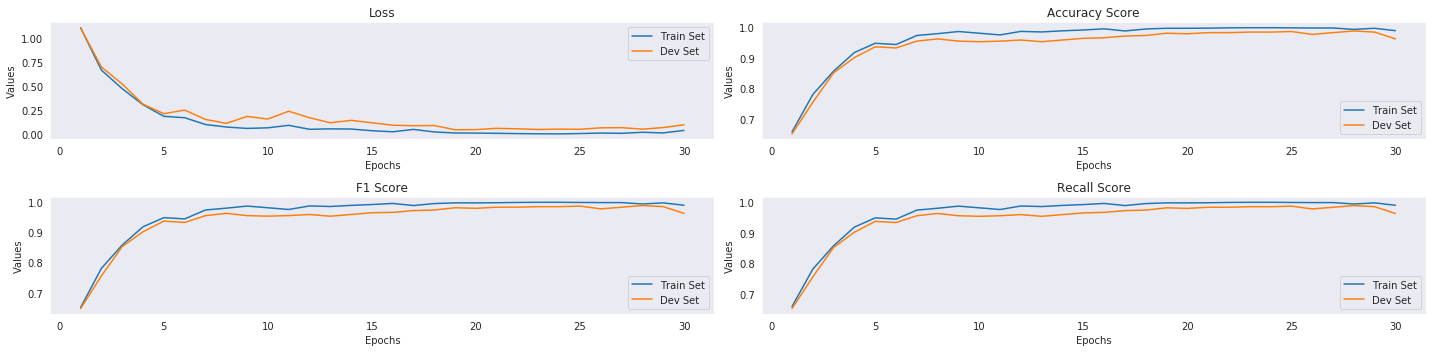

In [20]:
# Make instance of our model
BasicNet = ClfLSTM(input_dim=INPUT_SIZE, rnn_size=HIDDEN_LAYER, output_dim=OUTPUT_SIZE, num_layers=NUM_LAYERS)

# Make instance of our optimizer
optimizer = optim.Adam(BasicNet.parameters(), lr=ETA) 

# Start the training process 
main(BasicNet, optimizer, criterion, train_loader, dev_loader, EPOCHS)

###### Testing of BasicNet

In [21]:
test_loss, y_test_gold, y_test_pred = eval_lstm(test_loader, BasicNet, criterion)

print(f"Test Loss for BasicLSTM: {test_loss}")
print(f"Accuracy Score for BasicLSTM: {accuracy_score(y_test_gold, y_test_pred)}")
print(f"F1 Score for BasicLSTM: {f1_score(y_test_gold, y_test_pred, average='macro')}")
print(f"Recall Score for BasicLSTM: {recall_score(y_test_gold, y_test_pred, average='macro')}")

Test Loss for BasicLSTM: 0.09786643578928296
Accuracy Score for BasicLSTM: 0.97
F1 Score for BasicLSTM: 0.9700176252197232
Recall Score for BasicLSTM: 0.9700000000000001


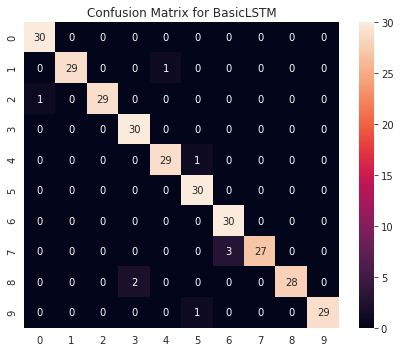

In [22]:
plot_conf_mat(y_test_gold,y_test_pred,'BasicLSTM')

#### Subtask 5 - Dropout and L2 Reguralization

In [23]:
# Define the additional training parameters
weight_decay = 1e-7
dropout = .2

###### Training of AdvancedLSTM

  0%|          | 0/30 [00:00<?, ?it/s]

 [========================================] ...Epoch 1, Loss: 1.3292
Statistics for the Train Set
	 Epoch: 1 	 Accuracy Score: 0.6625
	 Epoch: 1 	 f1 Score: 0.6576653743341121
	 Epoch: 1 	 recall Score: 0.6625000000000001


  3%|▎         | 1/30 [00:05<02:32,  5.27s/it]

Statistics for the Dev Set
	 Epoch: 1 	 loss: 1.0886150289556011
	 Epoch: 1 	 Accuracy Score: 0.674074074074074
	 Epoch: 1 	 f1 Score: 0.6697879002438574
	 Epoch: 1 	 recall Score: 0.674074074074074
Epoch total time 5.26941704750061
 [========================================] ...Epoch 2, Loss: 1.1385
Statistics for the Train Set
	 Epoch: 2 	 Accuracy Score: 0.774537037037037
	 Epoch: 2 	 f1 Score: 0.7703844877720497
	 Epoch: 2 	 recall Score: 0.7745370370370369


  7%|▋         | 2/30 [00:10<02:27,  5.26s/it]

Statistics for the Dev Set
	 Epoch: 2 	 loss: 0.8241124466617451
	 Epoch: 2 	 Accuracy Score: 0.7481481481481481
	 Epoch: 2 	 f1 Score: 0.7439225941195055
	 Epoch: 2 	 recall Score: 0.7481481481481481
Epoch total time 5.239498138427734
 [========================================] ...Epoch 3, Loss: 0.8067
Statistics for the Train Set
	 Epoch: 3 	 Accuracy Score: 0.8523148148148149
	 Epoch: 3 	 f1 Score: 0.8507615743294877
	 Epoch: 3 	 recall Score: 0.8523148148148149


 10%|█         | 3/30 [00:15<02:21,  5.24s/it]

Statistics for the Dev Set
	 Epoch: 3 	 loss: 0.6257443653752297
	 Epoch: 3 	 Accuracy Score: 0.8296296296296296
	 Epoch: 3 	 f1 Score: 0.8291378717893997
	 Epoch: 3 	 recall Score: 0.8296296296296296
Epoch total time 5.197571039199829
 [========================================] ...Epoch 4, Loss: 0.7245
Statistics for the Train Set
	 Epoch: 4 	 Accuracy Score: 0.9157407407407407
	 Epoch: 4 	 f1 Score: 0.9157986427516761
	 Epoch: 4 	 recall Score: 0.9157407407407406
Statistics for the Dev Set
	 Epoch: 4 	 loss: 0.41207764872632585
	 Epoch: 4 	 Accuracy Score: 0.8796296296296297
	 Epoch: 4 	 f1 Score: 0.8802030763421703


 13%|█▎        | 4/30 [00:20<02:16,  5.24s/it]

	 Epoch: 4 	 recall Score: 0.8796296296296295
Epoch total time 5.2199156284332275
 [========================================] ...Epoch 5, Loss: 0.5260
Statistics for the Train Set
	 Epoch: 5 	 Accuracy Score: 0.9393518518518519
	 Epoch: 5 	 f1 Score: 0.9392636572473061
	 Epoch: 5 	 recall Score: 0.9393518518518519
Statistics for the Dev Set
	 Epoch: 5 	 loss: 0.2972056980961491
	 Epoch: 5 	 Accuracy Score: 0.9166666666666666
	 Epoch: 5 	 f1 Score: 0.9165976829892191


 17%|█▋        | 5/30 [00:26<02:10,  5.22s/it]

	 Epoch: 5 	 recall Score: 0.9166666666666667
Epoch total time 5.189829587936401
 [========================================] ...Epoch 6, Loss: 0.5535
Statistics for the Train Set
	 Epoch: 6 	 Accuracy Score: 0.9444444444444444
	 Epoch: 6 	 f1 Score: 0.9444061164924479
	 Epoch: 6 	 recall Score: 0.9444444444444444
Statistics for the Dev Set
	 Epoch: 6 	 loss: 0.2932984872743198
	 Epoch: 6 	 Accuracy Score: 0.9203703703703704


 20%|██        | 6/30 [00:33<02:18,  5.77s/it]

	 Epoch: 6 	 f1 Score: 0.9207150661538263
	 Epoch: 6 	 recall Score: 0.9203703703703704
Epoch total time 7.0293333530426025
 [========================================] ...Epoch 7, Loss: 0.5068
Statistics for the Train Set
	 Epoch: 7 	 Accuracy Score: 0.9699074074074074
	 Epoch: 7 	 f1 Score: 0.9699427123281289
	 Epoch: 7 	 recall Score: 0.9699074074074074
Statistics for the Dev Set
	 Epoch: 7 	 loss: 0.21879412196863304
	 Epoch: 7 	 Accuracy Score: 0.924074074074074
	 Epoch: 7 	 f1 Score: 0.9245900055984311


 23%|██▎       | 7/30 [00:38<02:08,  5.61s/it]

	 Epoch: 7 	 recall Score: 0.924074074074074
Epoch total time 5.237635612487793
 [========================================] ...Epoch 8, Loss: 0.2945
Statistics for the Train Set
	 Epoch: 8 	 Accuracy Score: 0.9671296296296297
	 Epoch: 8 	 f1 Score: 0.9671257085833668
	 Epoch: 8 	 recall Score: 0.9671296296296296


 27%|██▋       | 8/30 [00:43<02:01,  5.54s/it]

Statistics for the Dev Set
	 Epoch: 8 	 loss: 0.2059078174073083
	 Epoch: 8 	 Accuracy Score: 0.9425925925925925
	 Epoch: 8 	 f1 Score: 0.9429284636501742
	 Epoch: 8 	 recall Score: 0.9425925925925925
Epoch total time 5.377755880355835
 [========================================] ...Epoch 9, Loss: 0.2788
Statistics for the Train Set
	 Epoch: 9 	 Accuracy Score: 0.9819444444444444
	 Epoch: 9 	 f1 Score: 0.9819364136066392
	 Epoch: 9 	 recall Score: 0.9819444444444445


 30%|███       | 9/30 [00:48<01:54,  5.44s/it]

Statistics for the Dev Set
	 Epoch: 9 	 loss: 0.1338438827243893
	 Epoch: 9 	 Accuracy Score: 0.9648148148148148
	 Epoch: 9 	 f1 Score: 0.9647029874068129
	 Epoch: 9 	 recall Score: 0.9648148148148149
Epoch total time 5.202787637710571
 [========================================] ...Epoch 10, Loss: 0.3412
Statistics for the Train Set
	 Epoch: 10 	 Accuracy Score: 0.975462962962963
	 Epoch: 10 	 f1 Score: 0.9754145256722916
	 Epoch: 10 	 recall Score: 0.9754629629629628
Statistics for the Dev Set
	 Epoch: 10 	 loss: 0.3020911694886471
	 Epoch: 10 	 Accuracy Score: 0.9444444444444444
	 Epoch: 10 	 f1 Score: 0.9443183898318628


 33%|███▎      | 10/30 [00:54<01:47,  5.37s/it]

	 Epoch: 10 	 recall Score: 0.9444444444444444
Epoch total time 5.1935975551605225
 [========================================] ...Epoch 11, Loss: 0.4246
Statistics for the Train Set
	 Epoch: 11 	 Accuracy Score: 0.950925925925926
	 Epoch: 11 	 f1 Score: 0.9502549331137619
	 Epoch: 11 	 recall Score: 0.950925925925926
Statistics for the Dev Set
	 Epoch: 11 	 loss: 0.21193367738996088
	 Epoch: 11 	 Accuracy Score: 0.9296296296296296
	 Epoch: 11 	 f1 Score: 0.9287723114812803


 37%|███▋      | 11/30 [00:59<01:41,  5.33s/it]

	 Epoch: 11 	 recall Score: 0.9296296296296296
Epoch total time 5.258432626724243
 [========================================] ...Epoch 12, Loss: 0.3984
Statistics for the Train Set
	 Epoch: 12 	 Accuracy Score: 0.9574074074074074
	 Epoch: 12 	 f1 Score: 0.9575328212276955
	 Epoch: 12 	 recall Score: 0.9574074074074073
Statistics for the Dev Set
	 Epoch: 12 	 loss: 0.2347068699917012
	 Epoch: 12 	 Accuracy Score: 0.9425925925925925
	 Epoch: 12 	 f1 Score: 0.9427189269922938


 40%|████      | 12/30 [01:04<01:35,  5.31s/it]

	 Epoch: 12 	 recall Score: 0.9425925925925925
Epoch total time 5.237376689910889
 [========================================] ...Epoch 13, Loss: 0.2520
Statistics for the Train Set
	 Epoch: 13 	 Accuracy Score: 0.9851851851851852
	 Epoch: 13 	 f1 Score: 0.9852259516508773
	 Epoch: 13 	 recall Score: 0.9851851851851852
Statistics for the Dev Set
	 Epoch: 13 	 loss: 0.10945411190004257
	 Epoch: 13 	 Accuracy Score: 0.9555555555555556
	 Epoch: 13 	 f1 Score: 0.9555288858687124


 43%|████▎     | 13/30 [01:09<01:29,  5.29s/it]

	 Epoch: 13 	 recall Score: 0.9555555555555555
Epoch total time 5.253704309463501
 [========================================] ...Epoch 14, Loss: 0.3267
Statistics for the Train Set
	 Epoch: 14 	 Accuracy Score: 0.9773148148148149
	 Epoch: 14 	 f1 Score: 0.9772498960770466
	 Epoch: 14 	 recall Score: 0.9773148148148149
Statistics for the Dev Set
	 Epoch: 14 	 loss: 0.14608208817167345
	 Epoch: 14 	 Accuracy Score: 0.9592592592592593
	 Epoch: 14 	 f1 Score: 0.9591398894559754


 47%|████▋     | 14/30 [01:15<01:24,  5.27s/it]

	 Epoch: 14 	 recall Score: 0.9592592592592594
Epoch total time 5.223286867141724
 [========================================] ...Epoch 15, Loss: 0.3602
Statistics for the Train Set
	 Epoch: 15 	 Accuracy Score: 0.9861111111111112
	 Epoch: 15 	 f1 Score: 0.9860975202321856
	 Epoch: 15 	 recall Score: 0.986111111111111
Statistics for the Dev Set
	 Epoch: 15 	 loss: 0.10666629227554114
	 Epoch: 15 	 Accuracy Score: 0.9666666666666667
	 Epoch: 15 	 f1 Score: 0.9664629104165968


 50%|█████     | 15/30 [01:20<01:19,  5.33s/it]

	 Epoch: 15 	 recall Score: 0.9666666666666666
Epoch total time 5.466615200042725
 [========================================] ...Epoch 16, Loss: 0.3111
Statistics for the Train Set
	 Epoch: 16 	 Accuracy Score: 0.9875
	 Epoch: 16 	 f1 Score: 0.9875154026607575
	 Epoch: 16 	 recall Score: 0.9875


 53%|█████▎    | 16/30 [01:30<01:32,  6.61s/it]

Statistics for the Dev Set
	 Epoch: 16 	 loss: 0.11871506755617474
	 Epoch: 16 	 Accuracy Score: 0.9685185185185186
	 Epoch: 16 	 f1 Score: 0.968512364674161
	 Epoch: 16 	 recall Score: 0.9685185185185186
Epoch total time 9.577746152877808
 [========================================] ...Epoch 17, Loss: 0.3138
Statistics for the Train Set
	 Epoch: 17 	 Accuracy Score: 0.9898148148148148
	 Epoch: 17 	 f1 Score: 0.9898230200429573
	 Epoch: 17 	 recall Score: 0.9898148148148147


 57%|█████▋    | 17/30 [01:40<01:39,  7.62s/it]

Statistics for the Dev Set
	 Epoch: 17 	 loss: 0.0832608254839001
	 Epoch: 17 	 Accuracy Score: 0.975925925925926
	 Epoch: 17 	 f1 Score: 0.9759180089966855
	 Epoch: 17 	 recall Score: 0.9759259259259258
Epoch total time 9.978421926498413
 [========================================] ...Epoch 18, Loss: 0.1933
Statistics for the Train Set
	 Epoch: 18 	 Accuracy Score: 0.9925925925925926
	 Epoch: 18 	 f1 Score: 0.992590372570745
	 Epoch: 18 	 recall Score: 0.9925925925925926


 60%|██████    | 18/30 [01:49<01:37,  8.15s/it]

Statistics for the Dev Set
	 Epoch: 18 	 loss: 0.08101211200702625
	 Epoch: 18 	 Accuracy Score: 0.9722222222222222
	 Epoch: 18 	 f1 Score: 0.9721778338652213
	 Epoch: 18 	 recall Score: 0.9722222222222221
Epoch total time 9.3982572555542
 [========================================] ...Epoch 19, Loss: 0.1752
Statistics for the Train Set
	 Epoch: 19 	 Accuracy Score: 0.9875
	 Epoch: 19 	 f1 Score: 0.9875278748052299
	 Epoch: 19 	 recall Score: 0.9874999999999998


 63%|██████▎   | 19/30 [02:01<01:40,  9.18s/it]

Statistics for the Dev Set
	 Epoch: 19 	 loss: 0.15911685734716338
	 Epoch: 19 	 Accuracy Score: 0.9592592592592593
	 Epoch: 19 	 f1 Score: 0.959423454094488
	 Epoch: 19 	 recall Score: 0.9592592592592591
Epoch total time 11.561867237091064
 [========================================] ...Epoch 20, Loss: 0.2895
Statistics for the Train Set
	 Epoch: 20 	 Accuracy Score: 0.9935185185185185
	 Epoch: 20 	 f1 Score: 0.993522768058481
	 Epoch: 20 	 recall Score: 0.9935185185185185


 67%|██████▋   | 20/30 [02:09<01:29,  8.93s/it]

Statistics for the Dev Set
	 Epoch: 20 	 loss: 0.08288414203781172
	 Epoch: 20 	 Accuracy Score: 0.975925925925926
	 Epoch: 20 	 f1 Score: 0.9759041141562509
	 Epoch: 20 	 recall Score: 0.975925925925926
Epoch total time 8.344207286834717
 [========================================] ...Epoch 21, Loss: 0.3177
Statistics for the Train Set
	 Epoch: 21 	 Accuracy Score: 0.9902777777777778
	 Epoch: 21 	 f1 Score: 0.9902785445853981
	 Epoch: 21 	 recall Score: 0.9902777777777778


 70%|███████   | 21/30 [02:17<01:18,  8.67s/it]

Statistics for the Dev Set
	 Epoch: 21 	 loss: 0.08927050338825711
	 Epoch: 21 	 Accuracy Score: 0.975925925925926
	 Epoch: 21 	 f1 Score: 0.975912179520454
	 Epoch: 21 	 recall Score: 0.9759259259259258
Epoch total time 8.05196762084961
 [========================================] ...Epoch 22, Loss: 0.2592
Statistics for the Train Set
	 Epoch: 22 	 Accuracy Score: 0.9898148148148148
	 Epoch: 22 	 f1 Score: 0.9898073940999403
	 Epoch: 22 	 recall Score: 0.9898148148148147


 73%|███████▎  | 22/30 [02:22<01:01,  7.63s/it]

Statistics for the Dev Set
	 Epoch: 22 	 loss: 0.09861280992281016
	 Epoch: 22 	 Accuracy Score: 0.9685185185185186
	 Epoch: 22 	 f1 Score: 0.9685094444044064
	 Epoch: 22 	 recall Score: 0.9685185185185186
Epoch total time 5.189257621765137
 [========================================] ...Epoch 23, Loss: 0.2493
Statistics for the Train Set
	 Epoch: 23 	 Accuracy Score: 0.9689814814814814
	 Epoch: 23 	 f1 Score: 0.968796848288496
	 Epoch: 23 	 recall Score: 0.9689814814814814
Statistics for the Dev Set
	 Epoch: 23 	 loss: 0.1786961411054478
	 Epoch: 23 	 Accuracy Score: 0.9537037037037037
	 Epoch: 23 	 f1 Score: 0.9536287953691727


 77%|███████▋  | 23/30 [02:28<00:48,  6.94s/it]

	 Epoch: 23 	 recall Score: 0.9537037037037038
Epoch total time 5.352917909622192
 [========================================] ...Epoch 24, Loss: 0.2482
Statistics for the Train Set
	 Epoch: 24 	 Accuracy Score: 0.9884259259259259
	 Epoch: 24 	 f1 Score: 0.9884251210635047
	 Epoch: 24 	 recall Score: 0.9884259259259259


 80%|████████  | 24/30 [02:33<00:38,  6.41s/it]

Statistics for the Dev Set
	 Epoch: 24 	 loss: 0.0900551324558864
	 Epoch: 24 	 Accuracy Score: 0.9703703703703703
	 Epoch: 24 	 f1 Score: 0.9703589387800058
	 Epoch: 24 	 recall Score: 0.9703703703703704
Epoch total time 5.173437595367432
 [========================================] ...Epoch 25, Loss: 0.2287
Statistics for the Train Set
	 Epoch: 25 	 Accuracy Score: 0.9930555555555556
	 Epoch: 25 	 f1 Score: 0.9930583125073366
	 Epoch: 25 	 recall Score: 0.9930555555555556


 83%|████████▎ | 25/30 [02:38<00:30,  6.06s/it]

Statistics for the Dev Set
	 Epoch: 25 	 loss: 0.10384884018399212
	 Epoch: 25 	 Accuracy Score: 0.9685185185185186
	 Epoch: 25 	 f1 Score: 0.9685023594701934
	 Epoch: 25 	 recall Score: 0.9685185185185186
Epoch total time 5.227319240570068
 [========================================] ...Epoch 26, Loss: 0.2083
Statistics for the Train Set
	 Epoch: 26 	 Accuracy Score: 0.9935185185185185
	 Epoch: 26 	 f1 Score: 0.9935266591594424
	 Epoch: 26 	 recall Score: 0.9935185185185185


 87%|████████▋ | 26/30 [02:43<00:23,  5.82s/it]

Statistics for the Dev Set
	 Epoch: 26 	 loss: 0.0702781899906461
	 Epoch: 26 	 Accuracy Score: 0.9685185185185186
	 Epoch: 26 	 f1 Score: 0.9687049190795877
	 Epoch: 26 	 recall Score: 0.9685185185185186
Epoch total time 5.262701034545898
 [========================================] ...Epoch 27, Loss: 0.2454
Statistics for the Train Set
	 Epoch: 27 	 Accuracy Score: 0.9962962962962963
	 Epoch: 27 	 f1 Score: 0.9962973332448986
	 Epoch: 27 	 recall Score: 0.9962962962962963


 90%|█████████ | 27/30 [02:49<00:16,  5.64s/it]

Statistics for the Dev Set
	 Epoch: 27 	 loss: 0.0961571892049253
	 Epoch: 27 	 Accuracy Score: 0.9814814814814815
	 Epoch: 27 	 f1 Score: 0.9814289930053832
	 Epoch: 27 	 recall Score: 0.9814814814814813
Epoch total time 5.216534614562988
 [========================================] ...Epoch 28, Loss: 0.1675
Statistics for the Train Set
	 Epoch: 28 	 Accuracy Score: 0.9953703703703703
	 Epoch: 28 	 f1 Score: 0.9953649348969238
	 Epoch: 28 	 recall Score: 0.9953703703703702


 93%|█████████▎| 28/30 [02:54<00:11,  5.51s/it]

Statistics for the Dev Set
	 Epoch: 28 	 loss: 0.06647086630318305
	 Epoch: 28 	 Accuracy Score: 0.9851851851851852
	 Epoch: 28 	 f1 Score: 0.9852767285051032
	 Epoch: 28 	 recall Score: 0.9851851851851852
Epoch total time 5.192508935928345
 [========================================] ...Epoch 29, Loss: 0.2232
Statistics for the Train Set
	 Epoch: 29 	 Accuracy Score: 0.9944444444444445
	 Epoch: 29 	 f1 Score: 0.994452731124254
	 Epoch: 29 	 recall Score: 0.9944444444444445
Statistics for the Dev Set
	 Epoch: 29 	 loss: 0.13093830148337657
	 Epoch: 29 	 Accuracy Score: 0.9796296296296296
	 Epoch: 29 	 f1 Score: 0.9797435337473231


 97%|█████████▋| 29/30 [02:59<00:05,  5.42s/it]

	 Epoch: 29 	 recall Score: 0.9796296296296296
Epoch total time 5.218325853347778
 [========================================] ...Epoch 30, Loss: 0.1819
Statistics for the Train Set
	 Epoch: 30 	 Accuracy Score: 0.9962962962962963
	 Epoch: 30 	 f1 Score: 0.9962993580022392
	 Epoch: 30 	 recall Score: 0.9962962962962962
Statistics for the Dev Set
	 Epoch: 30 	 loss: 0.07082397571715096
	 Epoch: 30 	 Accuracy Score: 0.9814814814814815


100%|██████████| 30/30 [03:04<00:00,  5.37s/it]

	 Epoch: 30 	 f1 Score: 0.9814604902479432
	 Epoch: 30 	 recall Score: 0.9814814814814815
Epoch total time 5.253498315811157
Training total time 184.59572577476501


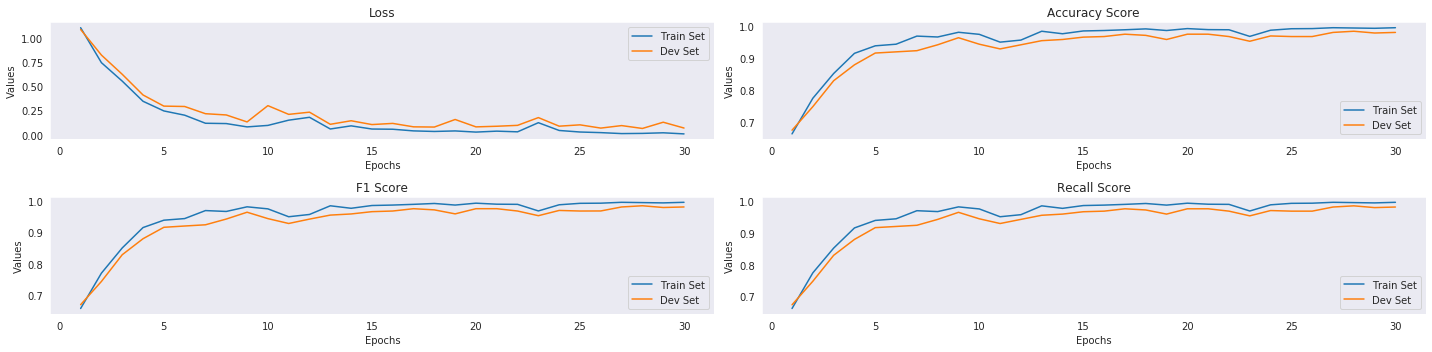

In [24]:
AdvancedNet = ClfLSTM(input_dim=INPUT_SIZE, rnn_size=HIDDEN_LAYER, output_dim=OUTPUT_SIZE, num_layers=NUM_LAYERS, dropout=dropout)

# Make instance of our optimizer, with L2-Reguralization
optimizer = optim.Adam(AdvancedNet.parameters(), lr=ETA, weight_decay=weight_decay) 

# Start the training process 
main(AdvancedNet, optimizer, criterion, train_loader, dev_loader, EPOCHS)

###### Testing of AdvancedNet

In [25]:
test_loss, y_test_gold, y_test_pred = eval_lstm(test_loader, AdvancedNet, criterion)

print(f"Test Loss for AdvancedLSTM: {test_loss}")
print(f"Accuracy Score for AdvancedLSTM: {accuracy_score(y_test_gold, y_test_pred)}")
print(f"F1 Score for AdvancedLSTM: {f1_score(y_test_gold, y_test_pred, average='macro')}")
print(f"Recall Score for AdvancedLSTM: {recall_score(y_test_gold, y_test_pred, average='macro')}")

Test Loss for AdvancedLSTM: 0.05519348181213008
Accuracy Score for AdvancedLSTM: 0.9866666666666667
F1 Score for AdvancedLSTM: 0.9866648143002685
Recall Score for AdvancedLSTM: 0.9866666666666667


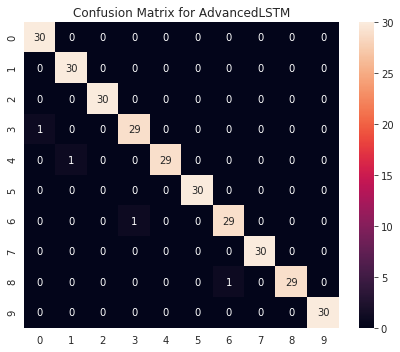

In [26]:
plot_conf_mat(y_test_gold,y_test_pred,'AdvancedLSTM')

#### SubTask 6 - Early Stopping / Checkpoints

In [27]:
# Define the additional training parameter for early tolerance
PATIENCE = 3

###### Training of EarlyAdvancedLSTM

  0%|          | 0/30 [00:00<?, ?it/s]

 [========================================] ...Epoch 1, Loss: 1.4082
Statistics for the Train Set
	 Epoch: 1 	 Accuracy Score: 0.6731481481481482
	 Epoch: 1 	 f1 Score: 0.664426265263603
	 Epoch: 1 	 recall Score: 0.673148148148148
Statistics for the Dev Set
	 Epoch: 1 	 loss: 1.082174261789563
	 Epoch: 1 	 Accuracy Score: 0.6814814814814815


  3%|▎         | 1/30 [00:05<02:33,  5.30s/it]

	 Epoch: 1 	 f1 Score: 0.6751280183163378
	 Epoch: 1 	 recall Score: 0.6814814814814816
Test loss decreased (inf --> 1.082174).  Saving model ...
Epoch total time 5.29694676399231
 [========================================] ...Epoch 2, Loss: 1.2486
Statistics for the Train Set
	 Epoch: 2 	 Accuracy Score: 0.7402777777777778
	 Epoch: 2 	 f1 Score: 0.7374294757340566
	 Epoch: 2 	 recall Score: 0.7402777777777778
Statistics for the Dev Set
	 Epoch: 2 	 loss: 0.8775970146368209
	 Epoch: 2 	 Accuracy Score: 0.7129629629629629
	 Epoch: 2 	 f1 Score: 0.7053582493901903


  7%|▋         | 2/30 [00:10<02:27,  5.27s/it]

	 Epoch: 2 	 recall Score: 0.712962962962963
Test loss decreased (1.082174 --> 0.877597).  Saving model ...
Epoch total time 5.1999218463897705
 [========================================] ...Epoch 3, Loss: 0.7644
Statistics for the Train Set
	 Epoch: 3 	 Accuracy Score: 0.8828703703703704
	 Epoch: 3 	 f1 Score: 0.88204225447673
	 Epoch: 3 	 recall Score: 0.8828703703703704
Statistics for the Dev Set
	 Epoch: 3 	 loss: 0.5466146533418008
	 Epoch: 3 	 Accuracy Score: 0.8759259259259259
	 Epoch: 3 	 f1 Score: 0.8754379008289547


 10%|█         | 3/30 [00:16<02:25,  5.38s/it]

	 Epoch: 3 	 recall Score: 0.875925925925926
Test loss decreased (0.877597 --> 0.546615).  Saving model ...
Epoch total time 5.638752698898315
 [========================================] ...Epoch 4, Loss: 0.6068
Statistics for the Train Set
	 Epoch: 4 	 Accuracy Score: 0.9175925925925926
	 Epoch: 4 	 f1 Score: 0.9176967594288381
	 Epoch: 4 	 recall Score: 0.9175925925925925
Statistics for the Dev Set
	 Epoch: 4 	 loss: 0.41381050262070807
	 Epoch: 4 	 Accuracy Score: 0.8870370370370371
	 Epoch: 4 	 f1 Score: 0.8856414813783587


 13%|█▎        | 4/30 [00:21<02:19,  5.37s/it]

	 Epoch: 4 	 recall Score: 0.8870370370370371
Test loss decreased (0.546615 --> 0.413811).  Saving model ...
Epoch total time 5.344310522079468
 [========================================] ...Epoch 5, Loss: 0.5440
Statistics for the Train Set
	 Epoch: 5 	 Accuracy Score: 0.9435185185185185
	 Epoch: 5 	 f1 Score: 0.9436613712813328
	 Epoch: 5 	 recall Score: 0.9435185185185185


 17%|█▋        | 5/30 [00:26<02:12,  5.31s/it]

Statistics for the Dev Set
	 Epoch: 5 	 loss: 0.2847368489219744
	 Epoch: 5 	 Accuracy Score: 0.9351851851851852
	 Epoch: 5 	 f1 Score: 0.9353315848313664
	 Epoch: 5 	 recall Score: 0.9351851851851853
Test loss decreased (0.413811 --> 0.284737).  Saving model ...
Epoch total time 5.184268474578857
 [========================================] ...Epoch 6, Loss: 0.3823
Statistics for the Train Set
	 Epoch: 6 	 Accuracy Score: 0.9587962962962963
	 Epoch: 6 	 f1 Score: 0.9587617101532825
	 Epoch: 6 	 recall Score: 0.9587962962962961


 20%|██        | 6/30 [00:31<02:06,  5.28s/it]

Statistics for the Dev Set
	 Epoch: 6 	 loss: 0.2619490213375748
	 Epoch: 6 	 Accuracy Score: 0.9259259259259259
	 Epoch: 6 	 f1 Score: 0.9261556008811624
	 Epoch: 6 	 recall Score: 0.9259259259259258
Test loss decreased (0.284737 --> 0.261949).  Saving model ...
Epoch total time 5.205939292907715
 [========================================] ...Epoch 7, Loss: 0.3115
Statistics for the Train Set
	 Epoch: 7 	 Accuracy Score: 0.9555555555555556
	 Epoch: 7 	 f1 Score: 0.9552888543066175
	 Epoch: 7 	 recall Score: 0.9555555555555555


 23%|██▎       | 7/30 [00:37<02:00,  5.26s/it]

Statistics for the Dev Set
	 Epoch: 7 	 loss: 0.22938994393100512
	 Epoch: 7 	 Accuracy Score: 0.9333333333333333
	 Epoch: 7 	 f1 Score: 0.9323358128413357
	 Epoch: 7 	 recall Score: 0.9333333333333332
Test loss decreased (0.261949 --> 0.229390).  Saving model ...
Epoch total time 5.1962971687316895
 [========================================] ...Epoch 8, Loss: 0.3483
Statistics for the Train Set
	 Epoch: 8 	 Accuracy Score: 0.9763888888888889
	 Epoch: 8 	 f1 Score: 0.9764553772985746
	 Epoch: 8 	 recall Score: 0.976388888888889
Statistics for the Dev Set
	 Epoch: 8 	 loss: 0.19570140171980702
	 Epoch: 8 	 Accuracy Score: 0.9333333333333333
	 Epoch: 8 	 f1 Score: 0.9328124529028965


 27%|██▋       | 8/30 [00:42<01:55,  5.24s/it]

	 Epoch: 8 	 recall Score: 0.9333333333333333
Test loss decreased (0.229390 --> 0.195701).  Saving model ...
Epoch total time 5.206808805465698
 [========================================] ...Epoch 9, Loss: 0.2887
Statistics for the Train Set
	 Epoch: 9 	 Accuracy Score: 0.9712962962962963
	 Epoch: 9 	 f1 Score: 0.9712892845255103
	 Epoch: 9 	 recall Score: 0.9712962962962963
Statistics for the Dev Set
	 Epoch: 9 	 loss: 0.21257258077662544
	 Epoch: 9 	 Accuracy Score: 0.9518518518518518
	 Epoch: 9 	 f1 Score: 0.9517073275720765


 30%|███       | 9/30 [00:47<01:49,  5.23s/it]

	 Epoch: 9 	 recall Score: 0.951851851851852
EarlyStopping counter: 1 out of 3
Epoch total time 5.203143358230591
 [========================================] ...Epoch 10, Loss: 0.3288
Statistics for the Train Set
	 Epoch: 10 	 Accuracy Score: 0.9814814814814815
	 Epoch: 10 	 f1 Score: 0.9814752172982522
	 Epoch: 10 	 recall Score: 0.9814814814814815


 33%|███▎      | 10/30 [00:52<01:44,  5.22s/it]

Statistics for the Dev Set
	 Epoch: 10 	 loss: 0.10937289512193864
	 Epoch: 10 	 Accuracy Score: 0.975925925925926
	 Epoch: 10 	 f1 Score: 0.9758974855853875
	 Epoch: 10 	 recall Score: 0.975925925925926
Test loss decreased (0.195701 --> 0.109373).  Saving model ...
Epoch total time 5.206563949584961
 [========================================] ...Epoch 11, Loss: 0.4655
Statistics for the Train Set
	 Epoch: 11 	 Accuracy Score: 0.9666666666666667
	 Epoch: 11 	 f1 Score: 0.9665557159705923
	 Epoch: 11 	 recall Score: 0.9666666666666668
Statistics for the Dev Set
	 Epoch: 11 	 loss: 0.1912373579639694
	 Epoch: 11 	 Accuracy Score: 0.95
	 Epoch: 11 	 f1 Score: 0.949807371314639


 37%|███▋      | 11/30 [00:57<01:38,  5.21s/it]

	 Epoch: 11 	 recall Score: 0.95
EarlyStopping counter: 1 out of 3
Epoch total time 5.17123007774353
 [========================================] ...Epoch 12, Loss: 0.3812
Statistics for the Train Set
	 Epoch: 12 	 Accuracy Score: 0.9949074074074075
	 Epoch: 12 	 f1 Score: 0.9949093313711737
	 Epoch: 12 	 recall Score: 0.9949074074074075
Statistics for the Dev Set
	 Epoch: 12 	 loss: 0.12280492536736971
	 Epoch: 12 	 Accuracy Score: 0.9703703703703703
	 Epoch: 12 	 f1 Score: 0.9702119271408772


 40%|████      | 12/30 [01:03<01:33,  5.21s/it]

	 Epoch: 12 	 recall Score: 0.9703703703703704
EarlyStopping counter: 2 out of 3
Epoch total time 5.205203294754028
 [========================================] ...Epoch 13, Loss: 0.2529
Statistics for the Train Set
	 Epoch: 13 	 Accuracy Score: 0.9861111111111112
	 Epoch: 13 	 f1 Score: 0.986079841033485
	 Epoch: 13 	 recall Score: 0.986111111111111
Statistics for the Dev Set
	 Epoch: 13 	 loss: 0.14019104902553983
	 Epoch: 13 	 Accuracy Score: 0.9722222222222222
	 Epoch: 13 	 f1 Score: 0.9720486822021884
	 Epoch: 13 	 recall Score: 0.9722222222222221
EarlyStopping counter: 3 out of 3
Training total time 63.059386253356934


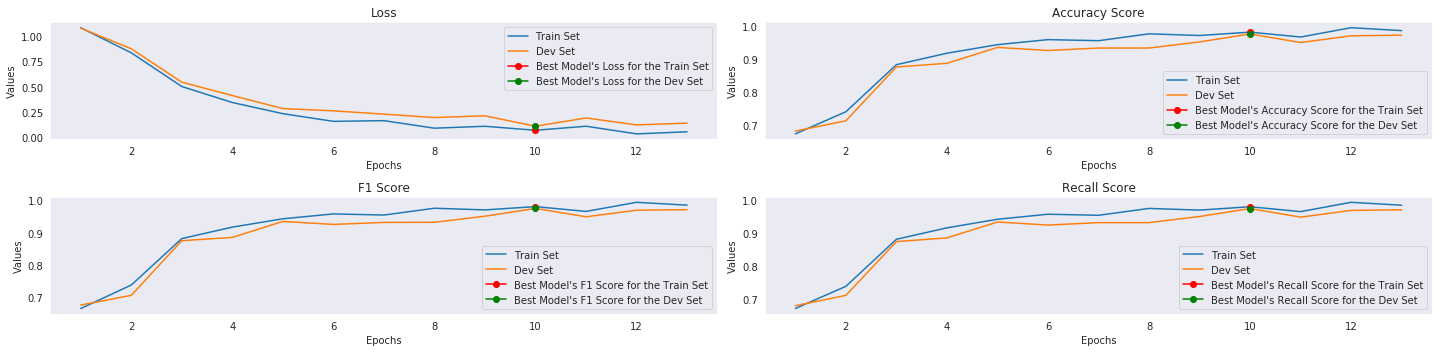

In [28]:
EarlyAdvancedNet = ClfLSTM(input_dim=INPUT_SIZE, rnn_size=HIDDEN_LAYER, output_dim=OUTPUT_SIZE, num_layers=NUM_LAYERS, dropout=dropout)

# Make instance of our optimizer, with L2-Reguralization
optimizer = optim.Adam(EarlyAdvancedNet.parameters(), lr=ETA, weight_decay=weight_decay) 

# Start the training process 
main(EarlyAdvancedNet, optimizer, criterion, train_loader, dev_loader, EPOCHS, net_name='EarlyAdvancedLSTM', PATIENCE=PATIENCE)

###### Testing of EarlyAdvancedNet

In [29]:
with open('./best_EarlyAdvancedLSTM.pickle', 'rb') as handle:
  E_model = pickle.load(handle)

test_loss, y_test_gold, y_test_pred = eval_lstm(test_loader, E_model, criterion)

print(f"Test Loss for EarlyAdvancedLSTM: {test_loss}")
print(f"Accuracy Score for EarlyAdvancedLSTM: {accuracy_score(y_test_gold, y_test_pred)}")
print(f"F1 Score for EarlyAdvancedLSTM: {f1_score(y_test_gold, y_test_pred, average='macro')}")
print(f"Recall Score for EarlyAdvancedLSTM: {recall_score(y_test_gold, y_test_pred, average='macro')}")

Test Loss for EarlyAdvancedLSTM: 0.13672537341324587
Accuracy Score for EarlyAdvancedLSTM: 0.9566666666666667
F1 Score for EarlyAdvancedLSTM: 0.9570621083875416
Recall Score for EarlyAdvancedLSTM: 0.9566666666666667


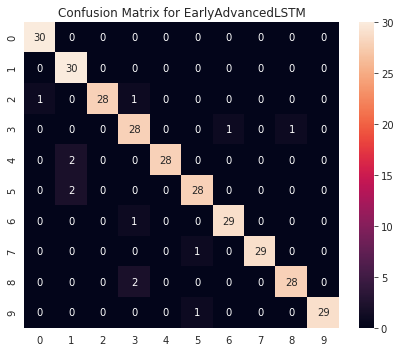

In [30]:
plot_conf_mat(y_test_gold,y_test_pred,'EarlyAdvancedLSTM')

#### SubTask 7 - Bidirectional

In [31]:
# Define the additional training parameter for bidirectional LSTM
bidirectional = True

###### Training of EarlyBiNet


  0%|          | 0/30 [00:00<?, ?it/s]

 [========================================] ...Epoch 1, Loss: 1.4338
Statistics for the Train Set
	 Epoch: 1 	 Accuracy Score: 0.7328703703703704
	 Epoch: 1 	 f1 Score: 0.7292181847960574
	 Epoch: 1 	 recall Score: 0.7328703703703703



  3%|▎         | 1/30 [00:12<05:48, 12.02s/it]

Statistics for the Dev Set
	 Epoch: 1 	 loss: 1.0323674562111826
	 Epoch: 1 	 Accuracy Score: 0.7203703703703703
	 Epoch: 1 	 f1 Score: 0.7141996775770745
	 Epoch: 1 	 recall Score: 0.7203703703703702
Test loss decreased (inf --> 1.032367).  Saving model ...
Epoch total time 12.01824164390564
 [========================================] ...Epoch 2, Loss: 0.9367
Statistics for the Train Set
	 Epoch: 2 	 Accuracy Score: 0.8435185185185186
	 Epoch: 2 	 f1 Score: 0.8431677654719092
	 Epoch: 2 	 recall Score: 0.8435185185185186



  7%|▋         | 2/30 [00:24<05:36, 12.02s/it]

Statistics for the Dev Set
	 Epoch: 2 	 loss: 0.6200146076044328
	 Epoch: 2 	 Accuracy Score: 0.8222222222222222
	 Epoch: 2 	 f1 Score: 0.8208938896993943
	 Epoch: 2 	 recall Score: 0.8222222222222223
Test loss decreased (1.032367 --> 0.620015).  Saving model ...
Epoch total time 12.012802839279175
 [========================================] ...Epoch 3, Loss: 0.5817
Statistics for the Train Set
	 Epoch: 3 	 Accuracy Score: 0.9166666666666666
	 Epoch: 3 	 f1 Score: 0.9166766036870235
	 Epoch: 3 	 recall Score: 0.9166666666666666



 10%|█         | 3/30 [00:35<05:23, 11.99s/it]

Statistics for the Dev Set
	 Epoch: 3 	 loss: 0.37747925345740996
	 Epoch: 3 	 Accuracy Score: 0.8925925925925926
	 Epoch: 3 	 f1 Score: 0.8923840330486742
	 Epoch: 3 	 recall Score: 0.8925925925925926
Test loss decreased (0.620015 --> 0.377479).  Saving model ...
Epoch total time 11.912890672683716
 [========================================] ...Epoch 4, Loss: 0.5059
Statistics for the Train Set
	 Epoch: 4 	 Accuracy Score: 0.9486111111111111
	 Epoch: 4 	 f1 Score: 0.9487072045064314
	 Epoch: 4 	 recall Score: 0.9486111111111111



 13%|█▎        | 4/30 [00:48<05:14, 12.11s/it]

Statistics for the Dev Set
	 Epoch: 4 	 loss: 0.24928787687193124
	 Epoch: 4 	 Accuracy Score: 0.9222222222222223
	 Epoch: 4 	 f1 Score: 0.9221864814709029
	 Epoch: 4 	 recall Score: 0.9222222222222222
Test loss decreased (0.377479 --> 0.249288).  Saving model ...
Epoch total time 12.38297414779663
 [========================================] ...Epoch 5, Loss: 0.4057
Statistics for the Train Set
	 Epoch: 5 	 Accuracy Score: 0.962037037037037
	 Epoch: 5 	 f1 Score: 0.9618637768154106
	 Epoch: 5 	 recall Score: 0.962037037037037



 17%|█▋        | 5/30 [01:00<05:01, 12.05s/it]

Statistics for the Dev Set
	 Epoch: 5 	 loss: 0.2045915830878883
	 Epoch: 5 	 Accuracy Score: 0.9518518518518518
	 Epoch: 5 	 f1 Score: 0.9515438556632164
	 Epoch: 5 	 recall Score: 0.951851851851852
Test loss decreased (0.249288 --> 0.204592).  Saving model ...
Epoch total time 11.895522594451904
 [========================================] ...Epoch 6, Loss: 0.4163
Statistics for the Train Set
	 Epoch: 6 	 Accuracy Score: 0.9606481481481481
	 Epoch: 6 	 f1 Score: 0.960694751336818
	 Epoch: 6 	 recall Score: 0.9606481481481481



 20%|██        | 6/30 [01:12<04:48, 12.02s/it]

Statistics for the Dev Set
	 Epoch: 6 	 loss: 0.19347652888896666
	 Epoch: 6 	 Accuracy Score: 0.9518518518518518
	 Epoch: 6 	 f1 Score: 0.9518817761150649
	 Epoch: 6 	 recall Score: 0.951851851851852
Test loss decreased (0.204592 --> 0.193477).  Saving model ...
Epoch total time 11.922531843185425
 [========================================] ...Epoch 7, Loss: 0.2678
Statistics for the Train Set
	 Epoch: 7 	 Accuracy Score: 0.9689814814814814
	 Epoch: 7 	 f1 Score: 0.9690242670949276
	 Epoch: 7 	 recall Score: 0.9689814814814814



 23%|██▎       | 7/30 [01:24<04:35, 12.00s/it]

Statistics for the Dev Set
	 Epoch: 7 	 loss: 0.11847151993588034
	 Epoch: 7 	 Accuracy Score: 0.9611111111111111
	 Epoch: 7 	 f1 Score: 0.9609175561274814
	 Epoch: 7 	 recall Score: 0.961111111111111
Test loss decreased (0.193477 --> 0.118472).  Saving model ...
Epoch total time 11.946080446243286
 [========================================] ...Epoch 8, Loss: 0.4296
Statistics for the Train Set
	 Epoch: 8 	 Accuracy Score: 0.9856481481481482
	 Epoch: 8 	 f1 Score: 0.9856495706260459
	 Epoch: 8 	 recall Score: 0.9856481481481479



 27%|██▋       | 8/30 [01:36<04:23, 11.99s/it]

Statistics for the Dev Set
	 Epoch: 8 	 loss: 0.1177509754831471
	 Epoch: 8 	 Accuracy Score: 0.9740740740740741
	 Epoch: 8 	 f1 Score: 0.974109879139968
	 Epoch: 8 	 recall Score: 0.9740740740740741
Test loss decreased (0.118472 --> 0.117751).  Saving model ...
Epoch total time 11.977352142333984
 [========================================] ...Epoch 9, Loss: 0.2999
Statistics for the Train Set
	 Epoch: 9 	 Accuracy Score: 0.9898148148148148
	 Epoch: 9 	 f1 Score: 0.9898050979409586
	 Epoch: 9 	 recall Score: 0.9898148148148149



 30%|███       | 9/30 [01:48<04:11, 11.99s/it]

Statistics for the Dev Set
	 Epoch: 9 	 loss: 0.07673935644098091
	 Epoch: 9 	 Accuracy Score: 0.975925925925926
	 Epoch: 9 	 f1 Score: 0.975973309679263
	 Epoch: 9 	 recall Score: 0.975925925925926
Test loss decreased (0.117751 --> 0.076739).  Saving model ...
Epoch total time 11.958757877349854
 [========================================] ...Epoch 10, Loss: 0.1630
Statistics for the Train Set
	 Epoch: 10 	 Accuracy Score: 0.9916666666666667
	 Epoch: 10 	 f1 Score: 0.9916293089254836
	 Epoch: 10 	 recall Score: 0.9916666666666666



 33%|███▎      | 10/30 [02:00<03:59, 11.96s/it]

Statistics for the Dev Set
	 Epoch: 10 	 loss: 0.06267953597713051
	 Epoch: 10 	 Accuracy Score: 0.9851851851851852
	 Epoch: 10 	 f1 Score: 0.9851807638770603
	 Epoch: 10 	 recall Score: 0.9851851851851853
Test loss decreased (0.076739 --> 0.062680).  Saving model ...
Epoch total time 11.907427072525024
 [========================================] ...Epoch 11, Loss: 0.3027
Statistics for the Train Set
	 Epoch: 11 	 Accuracy Score: 0.9949074074074075
	 Epoch: 11 	 f1 Score: 0.9949041625315054
	 Epoch: 11 	 recall Score: 0.9949074074074075



 37%|███▋      | 11/30 [02:11<03:47, 11.97s/it]

Statistics for the Dev Set
	 Epoch: 11 	 loss: 0.05354729234558647
	 Epoch: 11 	 Accuracy Score: 0.9888888888888889
	 Epoch: 11 	 f1 Score: 0.9889050931158451
	 Epoch: 11 	 recall Score: 0.9888888888888887
Test loss decreased (0.062680 --> 0.053547).  Saving model ...
Epoch total time 11.968331098556519
 [========================================] ...Epoch 12, Loss: 0.3169
Statistics for the Train Set
	 Epoch: 12 	 Accuracy Score: 0.9833333333333333
	 Epoch: 12 	 f1 Score: 0.9832762476863985
	 Epoch: 12 	 recall Score: 0.9833333333333334



 40%|████      | 12/30 [02:24<03:37, 12.11s/it]

Statistics for the Dev Set
	 Epoch: 12 	 loss: 0.11835049309173373
	 Epoch: 12 	 Accuracy Score: 0.9740740740740741
	 Epoch: 12 	 f1 Score: 0.9740400751847895
	 Epoch: 12 	 recall Score: 0.9740740740740741
EarlyStopping counter: 1 out of 3
Epoch total time 12.418890237808228
 [========================================] ...Epoch 13, Loss: 0.3831
Statistics for the Train Set
	 Epoch: 13 	 Accuracy Score: 0.9833333333333333
	 Epoch: 13 	 f1 Score: 0.9831835003766731
	 Epoch: 13 	 recall Score: 0.9833333333333334



 43%|████▎     | 13/30 [02:36<03:24, 12.06s/it]

Statistics for the Dev Set
	 Epoch: 13 	 loss: 0.09826678976093146
	 Epoch: 13 	 Accuracy Score: 0.9703703703703703
	 Epoch: 13 	 f1 Score: 0.970209764992655
	 Epoch: 13 	 recall Score: 0.9703703703703702
EarlyStopping counter: 2 out of 3
Epoch total time 11.931560277938843
 [========================================] ...Epoch 14, Loss: 0.4564
Statistics for the Train Set
	 Epoch: 14 	 Accuracy Score: 0.9662037037037037
	 Epoch: 14 	 f1 Score: 0.9665724872379287
	 Epoch: 14 	 recall Score: 0.9662037037037037
Statistics for the Dev Set
	 Epoch: 14 	 loss: 0.18553969369965317
	 Epoch: 14 	 Accuracy Score: 0.9425925925925925
	 Epoch: 14 	 f1 Score: 0.9430596254387409
	 Epoch: 14 	 recall Score: 0.9425925925925925
EarlyStopping counter: 3 out of 3
Training total time 156.25336289405823


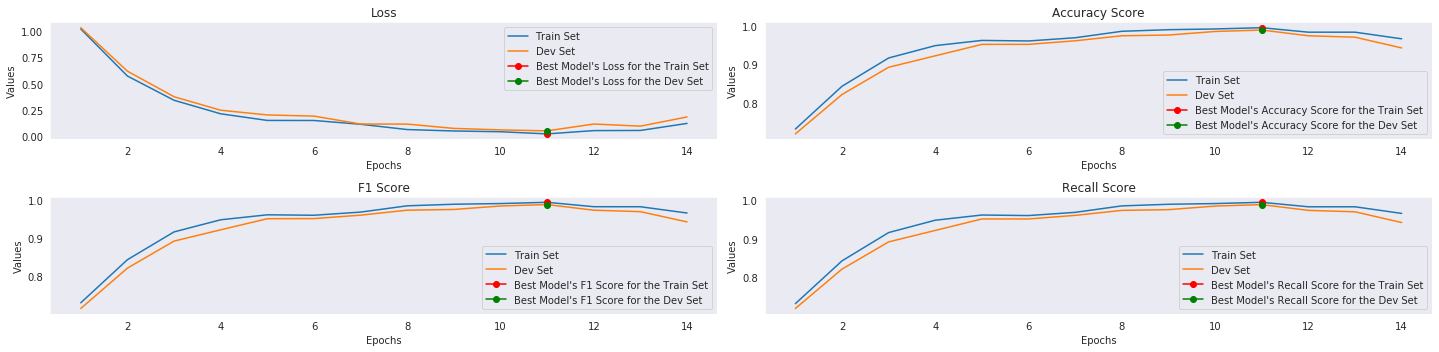

In [32]:
EarlyBiNet = ClfLSTM(input_dim=INPUT_SIZE, rnn_size=HIDDEN_LAYER, output_dim=OUTPUT_SIZE, num_layers=NUM_LAYERS, bidirectional=bidirectional, dropout=dropout)

# Make instance of our optimizer, with L2-Reguralization
optimizer = optim.Adam(EarlyBiNet.parameters(), lr=ETA, weight_decay=weight_decay) 

# Start the training process 
main(EarlyBiNet, optimizer, criterion, train_loader, dev_loader, EPOCHS, net_name='EarlyBiLSTM', PATIENCE=PATIENCE)

###### Testing of EarlyBiNet

In [33]:
with open('./best_EarlyBiLSTM.pickle', 'rb') as handle:
  E_model = pickle.load(handle)

test_loss, y_test_gold, y_test_pred = eval_lstm(test_loader, E_model, criterion)

print(f"Test Loss for EarlyBiLSTM: {test_loss}")
print(f"Accuracy Score for EarlyBiLSTM: {accuracy_score(y_test_gold, y_test_pred)}")
print(f"F1 Score for EarlyBiLSTM: {f1_score(y_test_gold, y_test_pred, average='macro')}")
print(f"Recall Score for EarlyBiLSTM: {recall_score(y_test_gold, y_test_pred, average='macro')}")

Test Loss for EarlyBiLSTM: 0.06851038500196227
Accuracy Score for EarlyBiLSTM: 0.9866666666666667
F1 Score for EarlyBiLSTM: 0.9867606446052566
Recall Score for EarlyBiLSTM: 0.9866666666666667


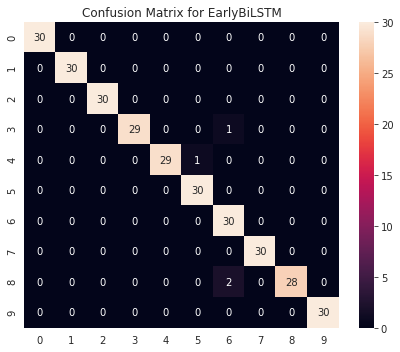

In [35]:
plot_conf_mat(y_test_gold,y_test_pred,'EarlyBiLSTM')

#### SubTask 8 (Bonus) - Complexity Improvement

In [36]:
# Define the additional training parameter for pack_padded_sequence implementation
pack_padded_sequence = True

###### Training of ImprovedEarlyBiLSTM



  0%|          | 0/30 [00:00<?, ?it/s]

 [========================================] ...Epoch 1, Loss: 1.4398
Statistics for the Train Set
	 Epoch: 1 	 Accuracy Score: 0.663425925925926
	 Epoch: 1 	 f1 Score: 0.6438082238939674




  3%|▎         | 1/30 [00:06<02:58,  6.15s/it]

	 Epoch: 1 	 recall Score: 0.6634259259259259
Statistics for the Dev Set
	 Epoch: 1 	 loss: 1.127620496623957
	 Epoch: 1 	 Accuracy Score: 0.6574074074074074
	 Epoch: 1 	 f1 Score: 0.6357397062924843
	 Epoch: 1 	 recall Score: 0.6574074074074073
Test loss decreased (inf --> 1.127620).  Saving model ...
Epoch total time 6.152974367141724
 [========================================] ...Epoch 2, Loss: 0.9977
Statistics for the Train Set
	 Epoch: 2 	 Accuracy Score: 0.7523148148148148
	 Epoch: 2 	 f1 Score: 0.7536428862195604




  7%|▋         | 2/30 [00:12<02:51,  6.14s/it]

	 Epoch: 2 	 recall Score: 0.7523148148148149
Statistics for the Dev Set
	 Epoch: 2 	 loss: 0.8603539515799458
	 Epoch: 2 	 Accuracy Score: 0.7240740740740741
	 Epoch: 2 	 f1 Score: 0.7257859067737306
	 Epoch: 2 	 recall Score: 0.7240740740740741
Test loss decreased (1.127620 --> 0.860354).  Saving model ...
Epoch total time 6.107736110687256
 [========================================] ...Epoch 3, Loss: 0.9999
Statistics for the Train Set
	 Epoch: 3 	 Accuracy Score: 0.8300925925925926
	 Epoch: 3 	 f1 Score: 0.8296389242478721
	 Epoch: 3 	 recall Score: 0.8300925925925927




 10%|█         | 3/30 [00:18<02:46,  6.16s/it]

Statistics for the Dev Set
	 Epoch: 3 	 loss: 0.7572299878766464
	 Epoch: 3 	 Accuracy Score: 0.8018518518518518
	 Epoch: 3 	 f1 Score: 0.8013810104616386
	 Epoch: 3 	 recall Score: 0.8018518518518519
Test loss decreased (0.860354 --> 0.757230).  Saving model ...
Epoch total time 6.19957971572876
 [========================================] ...Epoch 4, Loss: 0.7973
Statistics for the Train Set
	 Epoch: 4 	 Accuracy Score: 0.8986111111111111
	 Epoch: 4 	 f1 Score: 0.8982835334824821




 13%|█▎        | 4/30 [00:24<02:39,  6.15s/it]

	 Epoch: 4 	 recall Score: 0.898611111111111
Statistics for the Dev Set
	 Epoch: 4 	 loss: 0.456404703291307
	 Epoch: 4 	 Accuracy Score: 0.8888888888888888
	 Epoch: 4 	 f1 Score: 0.8877469263911746
	 Epoch: 4 	 recall Score: 0.8888888888888887
Test loss decreased (0.757230 --> 0.456405).  Saving model ...
Epoch total time 6.121302604675293
 [========================================] ...Epoch 5, Loss: 0.7132
Statistics for the Train Set
	 Epoch: 5 	 Accuracy Score: 0.9101851851851852
	 Epoch: 5 	 f1 Score: 0.9104415229569087




 17%|█▋        | 5/30 [00:30<02:33,  6.13s/it]

	 Epoch: 5 	 recall Score: 0.9101851851851851
Statistics for the Dev Set
	 Epoch: 5 	 loss: 0.4117714778234812
	 Epoch: 5 	 Accuracy Score: 0.8851851851851852
	 Epoch: 5 	 f1 Score: 0.8854940649993157
	 Epoch: 5 	 recall Score: 0.8851851851851851
Test loss decreased (0.456405 --> 0.411771).  Saving model ...
Epoch total time 6.086381912231445
 [========================================] ...Epoch 6, Loss: 0.6410
Statistics for the Train Set
	 Epoch: 6 	 Accuracy Score: 0.9319444444444445
	 Epoch: 6 	 f1 Score: 0.9313586781200043
	 Epoch: 6 	 recall Score: 0.9319444444444442




 20%|██        | 6/30 [00:36<02:27,  6.13s/it]

Statistics for the Dev Set
	 Epoch: 6 	 loss: 0.3134669783964433
	 Epoch: 6 	 Accuracy Score: 0.9259259259259259
	 Epoch: 6 	 f1 Score: 0.9252677272319956
	 Epoch: 6 	 recall Score: 0.9259259259259259
Test loss decreased (0.411771 --> 0.313467).  Saving model ...
Epoch total time 6.109086275100708
 [========================================] ...Epoch 7, Loss: 0.4202
Statistics for the Train Set
	 Epoch: 7 	 Accuracy Score: 0.9319444444444445
	 Epoch: 7 	 f1 Score: 0.9316354376070152




 23%|██▎       | 7/30 [00:42<02:20,  6.10s/it]

	 Epoch: 7 	 recall Score: 0.9319444444444445
Statistics for the Dev Set
	 Epoch: 7 	 loss: 0.2989250001267126
	 Epoch: 7 	 Accuracy Score: 0.9092592592592592
	 Epoch: 7 	 f1 Score: 0.9085386501217302
	 Epoch: 7 	 recall Score: 0.9092592592592593
Test loss decreased (0.313467 --> 0.298925).  Saving model ...
Epoch total time 6.035384654998779
 [========================================] ...Epoch 8, Loss: 0.4147
Statistics for the Train Set
	 Epoch: 8 	 Accuracy Score: 0.9486111111111111
	 Epoch: 8 	 f1 Score: 0.9480472619067692




 27%|██▋       | 8/30 [00:48<02:12,  6.04s/it]

	 Epoch: 8 	 recall Score: 0.9486111111111111
Statistics for the Dev Set
	 Epoch: 8 	 loss: 0.2724716647536852
	 Epoch: 8 	 Accuracy Score: 0.9259259259259259
	 Epoch: 8 	 f1 Score: 0.9249812223124794
	 Epoch: 8 	 recall Score: 0.9259259259259259
Test loss decreased (0.298925 --> 0.272472).  Saving model ...
Epoch total time 5.892273664474487
 [========================================] ...Epoch 9, Loss: 0.3997
Statistics for the Train Set
	 Epoch: 9 	 Accuracy Score: 0.9680555555555556
	 Epoch: 9 	 f1 Score: 0.9678682761804284




 30%|███       | 9/30 [00:54<02:07,  6.07s/it]

	 Epoch: 9 	 recall Score: 0.9680555555555556
Statistics for the Dev Set
	 Epoch: 9 	 loss: 0.14042257918869788
	 Epoch: 9 	 Accuracy Score: 0.9555555555555556
	 Epoch: 9 	 f1 Score: 0.9550054794061319
	 Epoch: 9 	 recall Score: 0.9555555555555555
Test loss decreased (0.272472 --> 0.140423).  Saving model ...
Epoch total time 6.117371320724487
 [========================================] ...Epoch 10, Loss: 0.3234
Statistics for the Train Set
	 Epoch: 10 	 Accuracy Score: 0.9800925925925926
	 Epoch: 10 	 f1 Score: 0.9801124440344902




 33%|███▎      | 10/30 [01:01<02:02,  6.12s/it]

	 Epoch: 10 	 recall Score: 0.9800925925925925
Statistics for the Dev Set
	 Epoch: 10 	 loss: 0.09486000723278502
	 Epoch: 10 	 Accuracy Score: 0.975925925925926
	 Epoch: 10 	 f1 Score: 0.9760225523936574
	 Epoch: 10 	 recall Score: 0.975925925925926
Test loss decreased (0.140423 --> 0.094860).  Saving model ...
Epoch total time 6.242188930511475
 [========================================] ...Epoch 11, Loss: 0.3978
Statistics for the Train Set
	 Epoch: 11 	 Accuracy Score: 0.9625
	 Epoch: 11 	 f1 Score: 0.9623833095556616




 37%|███▋      | 11/30 [01:07<01:56,  6.13s/it]

	 Epoch: 11 	 recall Score: 0.9625
Statistics for the Dev Set
	 Epoch: 11 	 loss: 0.17562158778524903
	 Epoch: 11 	 Accuracy Score: 0.9444444444444444
	 Epoch: 11 	 f1 Score: 0.9440306336643938
	 Epoch: 11 	 recall Score: 0.9444444444444444
EarlyStopping counter: 1 out of 3
Epoch total time 6.1328582763671875
 [========================================] ...Epoch 12, Loss: 0.3125
Statistics for the Train Set
	 Epoch: 12 	 Accuracy Score: 0.9740740740740741
	 Epoch: 12 	 f1 Score: 0.9740196766670355




 40%|████      | 12/30 [01:13<01:49,  6.09s/it]

	 Epoch: 12 	 recall Score: 0.9740740740740741
Statistics for the Dev Set
	 Epoch: 12 	 loss: 0.14114251734068642
	 Epoch: 12 	 Accuracy Score: 0.9537037037037037
	 Epoch: 12 	 f1 Score: 0.9537449997525117
	 Epoch: 12 	 recall Score: 0.9537037037037038
EarlyStopping counter: 2 out of 3
Epoch total time 5.974110126495361
 [========================================] ...Epoch 13, Loss: 0.3313
Statistics for the Train Set
	 Epoch: 13 	 Accuracy Score: 0.9875
	 Epoch: 13 	 f1 Score: 0.9874906038828419
	 Epoch: 13 	 recall Score: 0.9875
Statistics for the Dev Set
	 Epoch: 13 	 loss: 0.09653526568568409
	 Epoch: 13 	 Accuracy Score: 0.9777777777777777
	 Epoch: 13 	 f1 Score: 0.9776879946293136
	 Epoch: 13 	 recall Score: 0.9777777777777776
EarlyStopping counter: 3 out of 3
Training total time 73.17124795913696


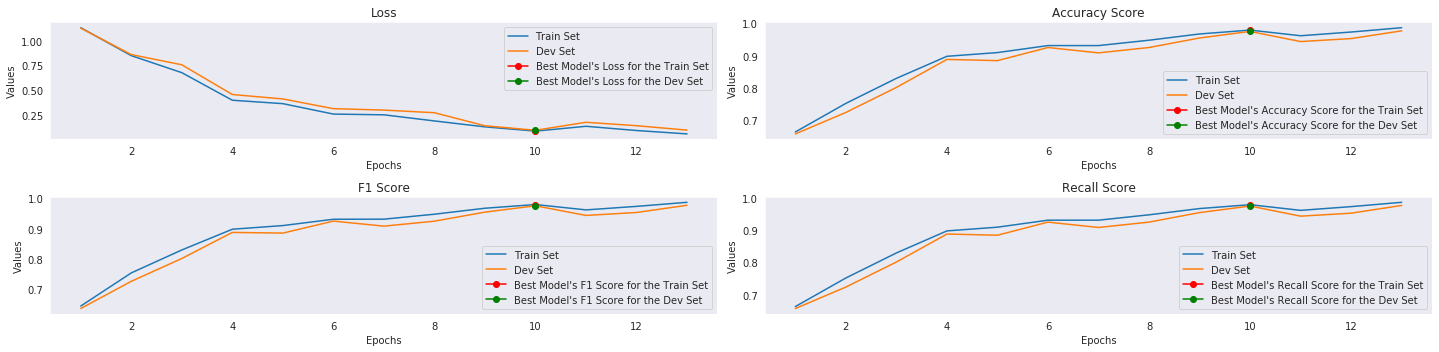

In [37]:
ImprovedEarlyBiNet = ClfLSTM(input_dim=INPUT_SIZE, rnn_size=HIDDEN_LAYER, output_dim=OUTPUT_SIZE, num_layers=NUM_LAYERS, dropout=dropout, pack_padded_sequence=pack_padded_sequence)

# Make instance of our optimizer, with L2-Reguralization
optimizer = optim.Adam(ImprovedEarlyBiNet.parameters(), lr=ETA, weight_decay=weight_decay) 

# Start the training process 
main(ImprovedEarlyBiNet, optimizer, criterion, train_loader, dev_loader, EPOCHS, net_name='ImprovedEarlyBiLSTM', PATIENCE=PATIENCE)

###### Testing of EarlyAdvancedNet

In [38]:
with open('./best_ImprovedEarlyBiLSTM.pickle', 'rb') as handle:
  E_model = pickle.load(handle)

test_loss, y_test_gold, y_test_pred = eval_lstm(test_loader, E_model, criterion)

print(f"Test Loss for ImprovedEarlyBiLSTM: {test_loss}")
print(f"Accuracy Score for ImprovedEarlyBiLSTM: {accuracy_score(y_test_gold, y_test_pred)}")
print(f"F1 Score for ImprovedEarlyBiLSTM: {f1_score(y_test_gold, y_test_pred, average='macro')}")
print(f"Recall Score for ImprovedEarlyBiLSTM: {recall_score(y_test_gold, y_test_pred, average='macro')}")

Test Loss for ImprovedEarlyBiLSTM: 0.15796859542549946
Accuracy Score for ImprovedEarlyBiLSTM: 0.9733333333333334
F1 Score for ImprovedEarlyBiLSTM: 0.9732654676935952
Recall Score for ImprovedEarlyBiLSTM: 0.9733333333333334


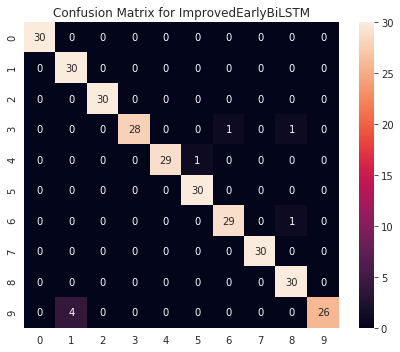

In [39]:
plot_conf_mat(y_test_gold,y_test_pred,'ImprovedEarlyBiLSTM')